last updated 11 03 24

This notebook is to get the run times for each model on the highest and lowest resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# imports
import torch
import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

from functions import import_imagedata, ImageProcessor, label_oh_tf
from fns4wandb import  set_lossfn
from architectures import sevennet, smallnet1, smallnet2, smallnet3
from loop_fns import loop
from plotting import learning_curve, accuracy_curve, plot_confusion

from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
import time

import csv
import json
import pickle
import os

import wandb

In [3]:
# file paths
_save_location = r'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/4c3l'

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = '3e677ef26b8873c6fc52a3f30d981e272ed228bd'

In [4]:
wandb.login()

wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [5]:
#!pip install datetime

d = date.today()
#print(str(d), type(str(d)))

452 144               5/452 *100 = 1%
226 72                5/226 *100 = 2%
113 36                5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57  18   (56.5,)      5/57 *100  = 8% -- 2/57 *100 = 3.5% ~ 4%.   1/57 = 1.75%
29   9   (28.5,)      5/29 *100  = 17% -- 2/29 *100 = 6.89 ~ 7%   1/28 = 3.57 ~ 4%
15   5   (14.5, 4.5)
8    3   (7.5,2.5)
4,   2   (, 1.5)

In [6]:
   

pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
  # flattern nested dictionary
  flatterend_dict = {}
  for k,v in nested_dict.items():
    if isinstance(v, dict):
      for nested_key, nested_val in v.items():
        flatterend_dict[f"{k}_{nested_key}"] = nested_val
    else:
      flatterend_dict[k] =v

  columns = list(flatterend_dict.keys())

  with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
      # using dictwriter
      writer = csv.DictWriter(f, fieldnames=columns)
      # using writeheader function
      if f.tell() == 0:
        writer.writeheader()
      writer.writerow(flatterend_dict)
      f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    #for model_card in config.model_cards:
    #print('\n choose_model \n MODEL NAME: ',model_name)

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        model_vgg16 = vgg16(weights="IMAGENET1K_V1")
        vgg_feats = model_vgg16.features
        vgg_classifier = model_vgg16.classifier
        vgg_classifier.pop(6)

        vgg = nn.Sequential(
            vgg_feats,
            Flattern(),
            vgg_classifier,
            nn.Linear(4096,11),
            nn.Softmax(dim=0),
            )
        return vgg
    else:
        print('Model Name Not Recognised')


In [7]:
# dictionaries

date = date.today()

model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                            ],
                 'idx': 0,
                 'dropout':0.2}


model_card_7c3l = {'name': '7c3l', 'model': '7c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[248832,    # 452 144    # p5
                            59904,      # 226 72     # p5
                            11264,      # 113  36    # p2
                            1536,       # 57 18      # p1
                            172032,           # 29  9
                            172032,          # 15 5
                            172032,         # 8 3
                              ], 
                   'idx': 1,
                  'dropout':0.2}



model_card_4c3l = {'name': '4c3l', 'model': '4c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[539904,    # 452 144    # p5
                             141056,    # 226 72     # p5
                             35840,     # 113  36    # p2 #304640 #35840
                             9984,      # 57 18      # p1
                             2304,      # 29  9
                             512,       # 15 5
                             256],      # 8 3
                  'idx': 2,
                  'dropout':0.2}      

model_card_3c2l = {'name': '3c2l', 'model': '3c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1069888,    # 452 144    # p5
                             274688,     #226 72      # p5
                             68096,      # 113  36    # p2
                             17280,      # 57 18      # p1
                             3840,       # 29  9
                             960,        # 15 5
                             256],
                  'idx': 3,
                  'dropout':0.2}       # 8 3

model_card_2c2l = {'name': '2c2l', 'model': '2c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1055232,    # 452 144    # p5
                             267264,     #226 72      # p5
                             64512,      # 113  36    # p2
                             15552,      # 57 18      # p1
                             3072,       # 29  9
                             640,        # 15 5
                             128],
                  'idx': 4,
                  'dropout':0.1}       # 8 3

resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [ resolution_card_11336, resolution_card_5715,
                    resolution_card_299, resolution_card_155, resolution_card_83] #resolution_card_452144, resolution_card_22672,
#resolution_cards = [resolution_card_11336]

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards =  [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [0.0001, 6e-5, 7e-5, 8e-5]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0, 0.1, 0.2]

seeds = [8,2,3] # 4, 5,6

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_4c3l]

loss_fn_cards = ['CrossEntropy'] #'MSE', 
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


#print(model_card_vgg)
#print('')
#pp.pprint(config) # dictionary of dictionaries of lists and lists of dictionaries

In [8]:

def train_val(model, x_train, x_val, y_train, y_val, res, pad, save_dict, lr, loss_fn, epochs,optimizer, scheduler_value,model_name, av_lum): #train_dl, val_dl, 


    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)#build_optimizer(mo
    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value) 
    #scheduler'
    ####
    
    #model = model.to(device)
    model.train()
    
    
    #losses= []
    #predictions = []
    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []

    
    total_epochs = 0
    for epoch in tqdm(range(epochs)):

        print('Training...')
    
        t_loss, train_prediction, t_correct, model, optimizer = loop(model=model, X=x_train, Y=y_train, loss_fn=loss_fn, device=device, 
                                                                     size= res,  pad=pad, num_classes=11, model_name= model_name, av_lum=av_lum,
                                                                     optimizer=optimizer) #,   scheduler =scheduler
        
        t_loss_list.append(t_loss)
        t_predict_list.append(train_prediction)
        wandb.log({'t_loss':t_loss})
        #wandb.log({'t_predict_list':train_prediction})
        #wandb.log({'train_labels':list(y_train)})
        train_acc = (t_correct/len(x_train)*100)
        print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
        #y_train_save = y_train.tolist()

        
        #clear_output()
        
            
        print('validating...')
        
        v_loss, val_prediction, val_correct= loop(model=model, X=x_val, Y=y_val, loss_fn=loss_fn, device=device,
                                                  size= res,  pad=pad, num_classes=11, model_name= model_name, 
                                                  av_lum=av_lum, train=False)
        #
        #scheduler.step()
        v_loss_list.append(v_loss)
        v_predict_list.append(val_prediction)
        wandb.log({'v_loss':v_loss})
        #wandb.log({'v_predict_list':val_prediction})
        #wandb.log({'y_val':list(y_val)})
        val_acc = (val_correct/len(x_val)*100)
        v_accuracy_list.append(val_acc)
        print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})

        #clear_output()
            
        total_epochs += 1
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(x_train)
    save_dict['validation_samples'] = len(x_val)

    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = y_train
    save_dict['v_labels'] = y_val
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    #wandb.log({'y_train':y_train})
    #wandb.log({'t_predict_list':t_predict_list})

    #wandb.log({'t_accuracy_list':t_accuracy_list})

    #y_val_save = y_val.tolist()
    
    
    #

    
    #wandb.log({'v_accuracy_list':v_accuracy_list})

    return model, save_dict

def test_loop(model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum, num_classes=11):
    model = model.eval()
    predict_list = []
    current_loss = 0
    total_count =0
    num_correct = 0
    correct = 0
    colour ='colour'
    size =  res

    with torch.no_grad():
        print('Testing...') 
        for idx, img in enumerate(X):

            #image pre processing
            prepro = ImageProcessor(device)
            if model_name == 'vgg16':
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True) #[29, 9], 15, 5, [8,3]
            elif (model_name == '7c3l' and size == [29, 9]) or (model_name == '7c3l' and size == [15, 5]) or (model_name == '7c3l' and size ==[8, 3]):
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True)
            else:
                tense = prepro.colour_size_tense(img, colour, size,av_lum,  pad)

            # send through model
            prediction = model.forward(tense)
            label = label_oh_tf(Y[idx], num_classes).to(device)
            loss = loss_fn(prediction, label)

            if prediction.argmax()==label.argmax():
                num_correct +=1
            total_count +=1
            correct +=(prediction.argmax()==label.argmax()).sum().item()

            predict_list.append(prediction.argmax())

        acc = num_correct/total_count
        accuracy = 100*(acc)
        
        
        
        current_loss += loss.item()
        
    return accuracy, predict_list, Y, current_loss


def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [9]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


def _go(config=None):
    
    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        print('Git Hash registered')
        
    with wandb.init(config=config, project=f"test 2 Run Big Loop", notes="First logging test of big loop. limitied data",):
        config = wandb.config
        start = time.process_time()
    
        for model_idx, model_card in enumerate(config['model_cards']):
            
            model_name = model_card['model']
            model_index = model_card['idx']
            dropout = model_card['dropout'] 
            
            
            for res_idx, resolution_card in enumerate(config['resolution_cards']):
    
                resolution = resolution_card['resolution']
                pad = resolution_card['padding']
               
                lin_lay = get_lin_lay(model_card, resolution)
    
                
                for lr_idx, lr in enumerate(config['learning_rate_cards']):
                    for wd_idx, wd_card in enumerate(wd_cards):
                        for sched_idx, scheduler_value in enumerate(config['scheduler_cards']):
                            for seed_idx, seed in enumerate(config['seeds']):
                                seed = seed
                                for lossfn_idx, lossfn in enumerate(config['loss_fn_cards']):
                                    
                                    
                                    #print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    #print(config.model_cards, len(config.model_cards), type(config.model_cards))
                                    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    print('resolution: ', str(resolution), f"  idx: {res_idx} / {len(config['resolution_cards'])}")
                                    print('learning rate: ', str(lr), f"  idx: {lr_idx} / {len(config['learning_rate_cards'])}")
                                    print('weight decay: ', str(wd_card), f"  idx: {wd_idx} / {len(config['wd_cards'])}")
                                    print('scheduler: ', str(scheduler_value), f"  idx: {sched_idx} / {len(config['scheduler_cards'])}")
                                    print('seed: ', str(seed), f"  idx:  {seed_idx} / {len(config['seeds'])}")
                                    print('loss function: ', str(lossfn), f" idx: {lossfn_idx} / {len(config['loss_fn_cards'])}")
                                    run_start_time = time.process_time()
                                    print(run_start_time)
   
                                    print(time.process_time() - start)
                                    
        
                                    epochs = 20 #40

                                    IP = ImageProcessor(device)

                                    print(f"Total epochs: {epochs}")
                                     
                                    wandb.log({'gitHash':gitHASH})
                                    wandb.log({'Epochs': epochs})
                                    # set save dictionary
                                    save_dict = {'Run' : f"{model_name}_{date}",
                                                 'Current_Epoch': 0,
                                                 'save_location' : _save_location}
                                    
                                    # set model
                                    model = choose_model(model_name, lin_lay, dropout).to(device)
                                    #print(model, '\n', type(config))
                                    # get image data
                                    x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                                    av_lum = IP.new_luminance(x_train)
                                    
                                    # set loss function
                                    loss_fn = set_lossfn(lossfn)
                                    
                                    # set optimizer
                                    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
                   
                                    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value, last_epoch=-1) 

                                    
                                    wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)
                                    model, save_dict=  train_val(model, x_train, x_val, y_train, y_val, resolution, pad, save_dict, lr, loss_fn,epochs, optimizer, scheduler_value,
                                                                   model_name, av_lum)

                                    #test                                               Y,          
                                    test_acc,test_predict_list, y_test, test_loss = test_loop(model, model_name, x_test, y_test,resolution, pad, save_dict,loss_fn,
                                                                                              device, av_lum, num_classes=11) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                                    
                                    #print(test_predict_list)
                                    print(' \n train acc: ', save_dict['t_accuracy_list'][-1])
                                    print(' \n val acc: ', save_dict['v_accuracy_list'][-1])
                                    print(' \n test acc: ', test_acc)
                                    
                                    save_dict.update({'test_acc': test_acc})
                                    save_dict.update({'test_predict': test_predict_list})
                                    save_dict.update({'test_labels': list(y_test)})
                                    save_dict.update({'test_loss':test_loss})

                                    loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{scheduler_value}_{seed}_{lossfn}"


                                    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
                                    accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
                                    test_predict_list=[pred.cpu() for pred in test_predict_list]
                                    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
                                    
                                    wandb.log({'test_acc': test_acc})
                                    wandb.log({'test_predict': test_predict_list})
                                    wandb.log({'test_labels': list(y_test)})
                                    #saving
                                    diction = {}
                                    d = date.today()
                                    d=str(d)
                                    diction.update({'Date':d})
                                    diction.update({'gitHASH':str(gitHASH)})
                                    diction.update({'model_name': str(model_name)})
                                    diction.update({'loss_fn': str(lossfn)})
                                    diction.update({'lr': str(lr)})
                                    diction.update({'wd': str(wd_card)})
                                    diction.update({'scheduler value': str(scheduler_value)})
                                    diction.update({'seed': str(seed)})
                                    diction.update({'resolution': str(resolution)})
                                    diction.update({'pad': int(pad)})
                                    diction.update({'lin_lay': int(lin_lay)})
                                    diction.update({'run time': (time.process_time() - run_start_time)})
                                    diction.update(save_dict)
                                    
                                    save_location = save_dict['save_location']
                                    title = save_dict['Run']
                                    save2json(diction, title, save_location)
                                    save2csv(diction, title, save_location)
        
                                    diction['model.state_dict'] = model.state_dict() #to('cpu').
        
                                    with open(f"{save_location}{loop_run_name}.pkl", 'wb+') as f:
                                        pickle.dump(diction, f)
                                    
                                    #clear_output()
                                    
                                    print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)

        print('Final Run time:  ',time.process_time() - start)

Git Hash registered


Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
10.563584296
0.0008257929999988534
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.58893515764426
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:25, 23.45s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.458655562165378
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:46<06:58, 23.23s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.58893515764426
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:10<06:39, 23.50s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.875074360499703
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:33<06:12, 23.31s/it]

validation accuracy:  14.840499306518723
Training...
train accuracy:  20.99940511600238
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:46, 23.11s/it]

validation accuracy:  30.235783633841883
Training...
train accuracy:  31.4098750743605
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:19<05:23, 23.14s/it]

validation accuracy:  35.22884882108183
Training...
train accuracy:  36.109458655562165
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:42<05:02, 23.30s/it]

validation accuracy:  38.28016643550624
Training...
train accuracy:  42.71267102914932
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:07<04:42, 23.55s/it]

validation accuracy:  37.86407766990291
Training...
train accuracy:  43.426531826293875
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:29<04:16, 23.29s/it]

validation accuracy:  45.07628294036061
Training...
train accuracy:  45.92504461629982
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:52<03:51, 23.15s/it]

validation accuracy:  42.44105409153953
Training...
train accuracy:  47.828673408685304
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:15<03:28, 23.22s/it]

validation accuracy:  46.04715672676838
Training...
train accuracy:  47.76918500892326
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:39<03:06, 23.32s/it]

validation accuracy:  45.07628294036061
Training...
train accuracy:  51.63593099345628
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [05:03<02:45, 23.59s/it]

validation accuracy:  48.54368932038835
Training...
train accuracy:  52.8256989886972
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:26<02:19, 23.32s/it]

validation accuracy:  47.71151178918169
Training...
train accuracy:  53.004164187983335
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:49<01:55, 23.20s/it]

validation accuracy:  48.82108183079057
Training...
train accuracy:  53.53955978584176
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:12<01:32, 23.08s/it]

validation accuracy:  49.375866851595006
Training...
train accuracy:  55.74063057703748
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:36<01:10, 23.46s/it]

validation accuracy:  49.51456310679612
Training...
train accuracy:  58.29863176680548
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [07:00<00:47, 23.57s/it]

validation accuracy:  50.20804438280167
Training...
train accuracy:  58.77453896490184
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:22<00:23, 23.27s/it]

validation accuracy:  48.54368932038835
Training...
train accuracy:  59.42891136228435
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:45<00:00, 23.29s/it]

validation accuracy:  49.79195561719833
Testing...


 
 train acc:  59.42891136228435
 
 val acc:  49.79195561719833
 
 test acc:  44.66019417475729


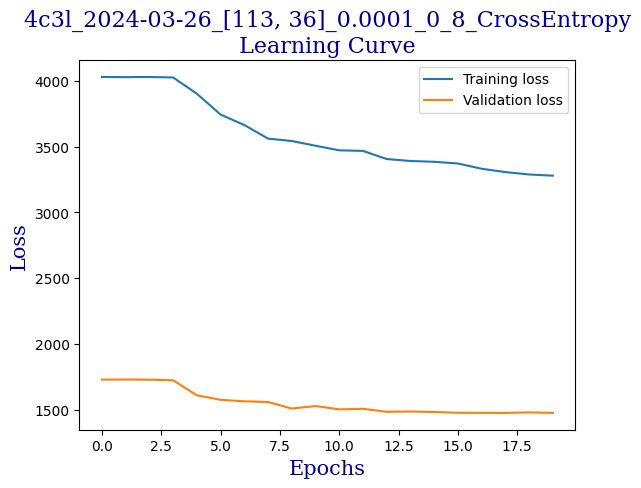

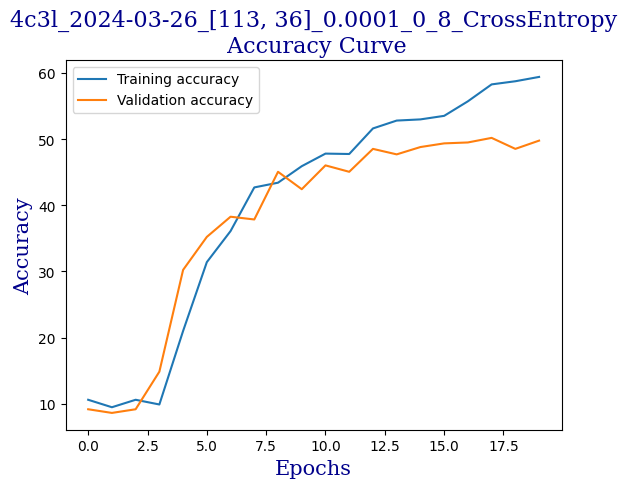

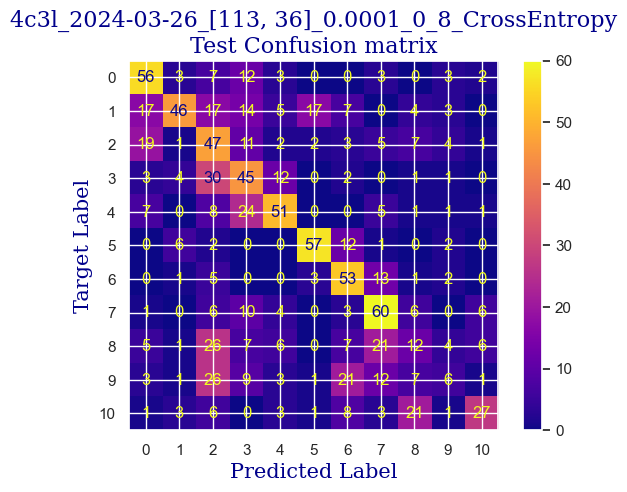

 
 END 4c3l [113, 36] Run Time:  476.228232403
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
486.792865451
476.230111192
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.648423557406305
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:12, 22.77s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.291493158834028
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:47, 22.65s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.469958358120167
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:28, 22.83s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:32<06:13, 23.33s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.945865556216537
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:45<04:52, 19.49s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.053539559785841
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:08<04:50, 20.77s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.767400356930398
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:30<04:37, 21.34s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.767400356930398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:52<04:18, 21.55s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.945865556216537
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:15<04:00, 21.91s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.113027959547887
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:38<03:42, 22.28s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  16.894705532421177
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:00<03:20, 22.27s/it]

validation accuracy:  19.41747572815534
Training...
train accuracy:  25.758477096966093
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:23<02:57, 22.20s/it]

validation accuracy:  24.271844660194176
Training...
train accuracy:  29.208804283164785
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:45<02:36, 22.41s/it]

validation accuracy:  29.403606102635226
Training...
train accuracy:  32.36168947055324
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:09<02:15, 22.65s/it]

validation accuracy:  30.79056865464632
Training...
train accuracy:  33.72992266508031
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:31<01:52, 22.43s/it]

validation accuracy:  34.25797503467407
Training...
train accuracy:  36.70434265318263
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:52<01:29, 22.28s/it]

validation accuracy:  29.26490984743412
Training...
train accuracy:  38.786436644854255
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:15<01:07, 22.49s/it]

validation accuracy:  30.374479889042995
Training...
train accuracy:  40.095181439619274
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:38<00:45, 22.58s/it]

validation accuracy:  34.674063800277395
Training...
train accuracy:  41.82034503271862
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:00<00:22, 22.36s/it]

validation accuracy:  32.73231622746186
Training...
train accuracy:  43.188578227245685
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:22<00:00, 22.13s/it]

validation accuracy:  35.50624133148405
Testing...


 
 train acc:  43.188578227245685
 
 val acc:  35.50624133148405
 
 test acc:  32.5242718446602


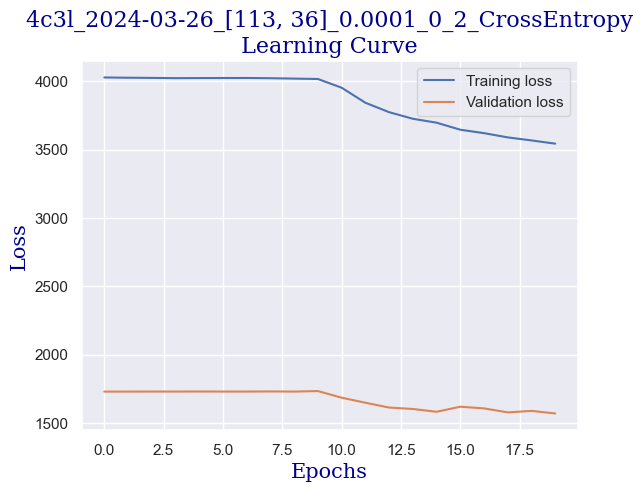

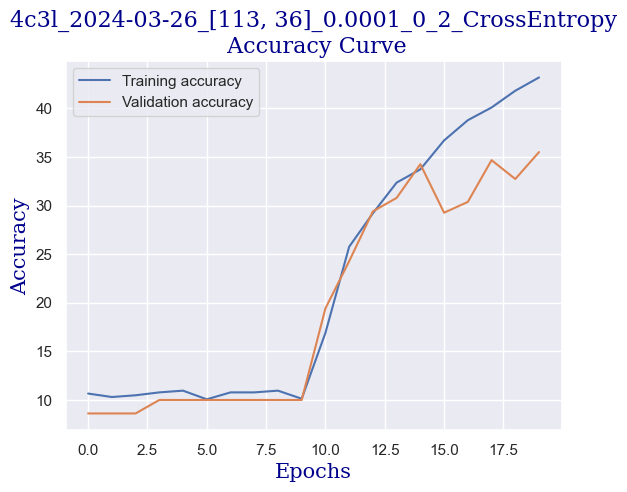

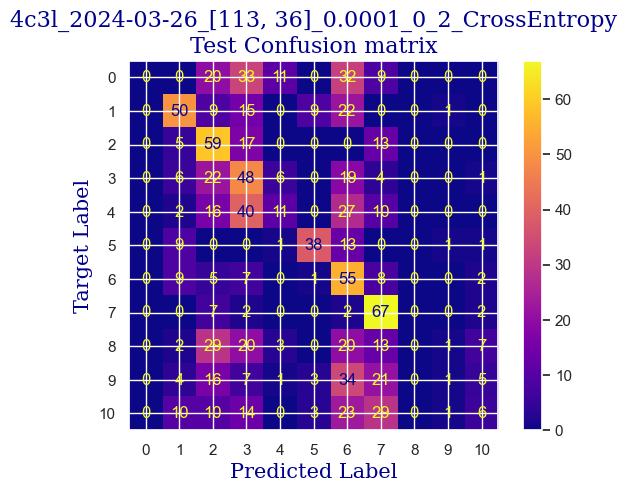

 
 END 4c3l [113, 36] Run Time:  449.45878526399997
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
936.252539569
925.689777841
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.030933967876264
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:00, 22.12s/it]

validation accuracy:  11.511789181692095
Training...
train accuracy:  10.113027959547887
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:49, 22.76s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.707911957168353
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:26, 22.72s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.1017251635931
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:29<05:58, 22.43s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:51<05:33, 22.26s/it]

validation accuracy:  10.957004160887656
Training...
train accuracy:  16.5377751338489
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:15<05:15, 22.54s/it]

validation accuracy:  22.191400832177532
Training...
train accuracy:  22.427126710291493
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:37<04:50, 22.36s/it]

validation accuracy:  28.01664355062413
Training...
train accuracy:  28.435455086258184
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:59<04:27, 22.29s/it]

validation accuracy:  32.87101248266297
Training...
train accuracy:  34.146341463414636
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:20<04:02, 22.08s/it]

validation accuracy:  35.78363384188627
Training...
train accuracy:  38.07257584770969
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:44<03:44, 22.44s/it]

validation accuracy:  36.33841886269071
Training...
train accuracy:  38.54848304580607
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:06<03:20, 22.33s/it]

validation accuracy:  38.00277392510402
Training...
train accuracy:  41.99881023200476
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:23<02:46, 20.86s/it]

validation accuracy:  39.25104022191401
Training...
train accuracy:  42.35574063057704
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:43<02:23, 20.46s/it]

validation accuracy:  35.78363384188627
Training...
train accuracy:  44.37834622248661
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:05<02:06, 21.16s/it]

validation accuracy:  42.302357836338416
Training...
train accuracy:  46.519928613920285
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:28<01:48, 21.66s/it]

validation accuracy:  41.33148404993065
Training...
train accuracy:  45.80606781677573
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:52<01:29, 22.41s/it]

validation accuracy:  43.27323162274618
Training...
train accuracy:  47.23378941106484
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:16<01:08, 22.74s/it]

validation accuracy:  39.528432732316226
Training...
train accuracy:  50.20820939916716
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:39<00:45, 22.84s/it]

validation accuracy:  40.77669902912621
Training...
train accuracy:  50.148720999405114
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:02<00:22, 22.83s/it]

validation accuracy:  44.10540915395285
Training...
train accuracy:  49.01844140392623
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:25<00:00, 22.26s/it]

validation accuracy:  42.857142857142854
Testing...


 
 train acc:  49.01844140392623
 
 val acc:  42.857142857142854
 
 test acc:  40.0


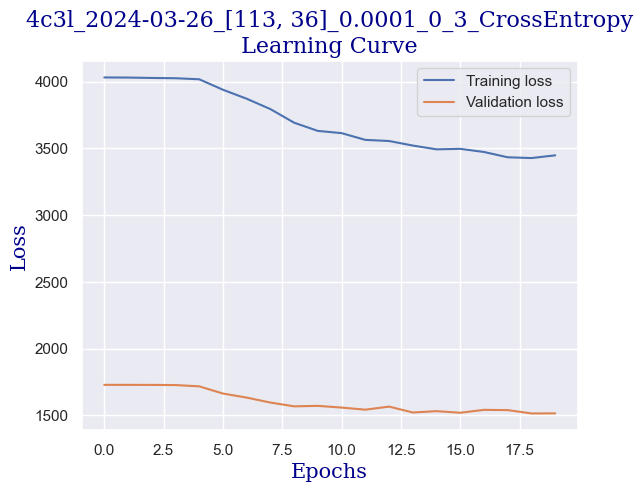

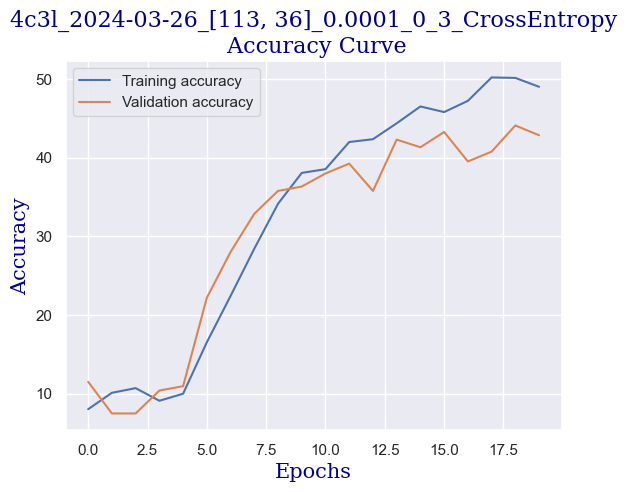

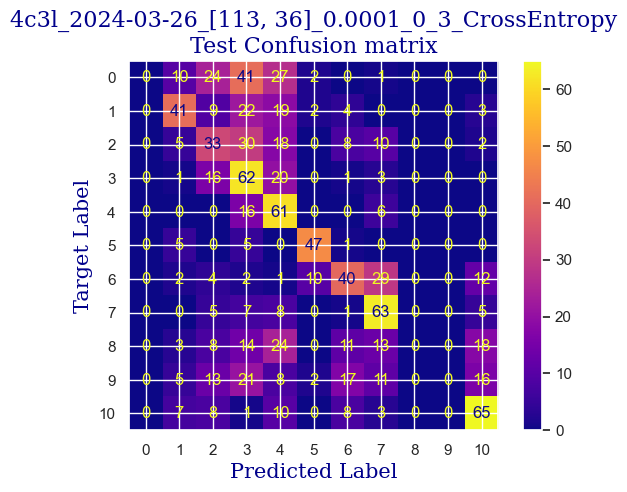

 
 END 4c3l [113, 36] Run Time:  451.9947770880001
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
1388.248752017
1377.686009642
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.280190362879239
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:15, 22.94s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.57763236168947
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:46<06:59, 23.30s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.994051160023796
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:10<06:41, 23.62s/it]

validation accuracy:  15.256588072122051
Training...
train accuracy:  17.430101130279596
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:33<06:13, 23.31s/it]

validation accuracy:  27.600554785020805
Training...
train accuracy:  25.520523497917907
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:47, 23.15s/it]

validation accuracy:  29.26490984743412
Training...
train accuracy:  31.35038667459845
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:18<05:22, 23.00s/it]

validation accuracy:  24.549237170596395
Training...
train accuracy:  33.8488994646044
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:42<05:02, 23.28s/it]

validation accuracy:  33.287101248266296
Training...
train accuracy:  36.04997025580012
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:06<04:41, 23.42s/it]

validation accuracy:  34.11927877947296
Training...
train accuracy:  39.85722784057109
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:29<04:14, 23.17s/it]

validation accuracy:  31.345353675450767
Training...
train accuracy:  41.16597263533611
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:51<03:49, 22.97s/it]

validation accuracy:  36.89320388349515
Training...
train accuracy:  42.23676383105294
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:14<03:26, 22.95s/it]

validation accuracy:  37.7253814147018
Training...
train accuracy:  44.14039262343843
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:38<03:05, 23.24s/it]

validation accuracy:  38.83495145631068
Training...
train accuracy:  47.35276621058894
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [05:01<02:41, 23.07s/it]

validation accuracy:  39.528432732316226
Training...
train accuracy:  47.531231409875076
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:23<02:17, 22.94s/it]

validation accuracy:  42.0249653259362
Training...
train accuracy:  50.62462819750149
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:46<01:54, 22.80s/it]

validation accuracy:  44.24410540915395
Training...
train accuracy:  53.12314098750743
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:09<01:32, 23.01s/it]

validation accuracy:  42.71844660194174
Training...
train accuracy:  54.19393218322427
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:33<01:09, 23.25s/it]

validation accuracy:  45.07628294036061
Training...
train accuracy:  57.049375371802505
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:46<00:40, 20.12s/it]

validation accuracy:  44.382801664355064
Training...
train accuracy:  58.00118976799524
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:10<00:21, 21.22s/it]

validation accuracy:  42.57975034674064
Training...
train accuracy:  59.19095776323617
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:32<00:00, 22.63s/it]

validation accuracy:  45.07628294036061
Testing...


 
 train acc:  59.19095776323617
 
 val acc:  45.07628294036061
 
 test acc:  41.94174757281554


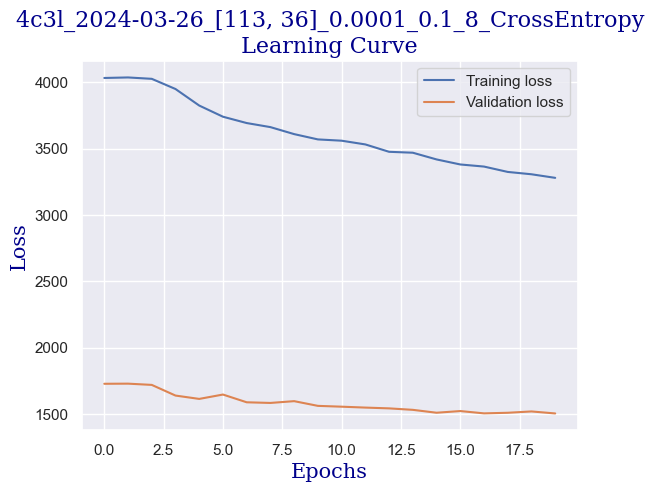

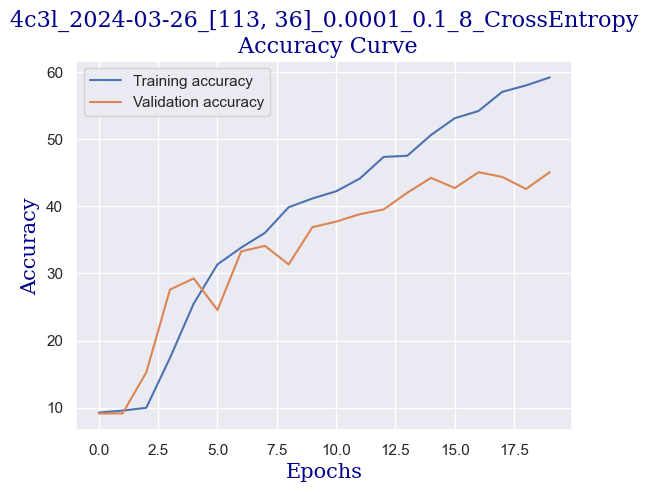

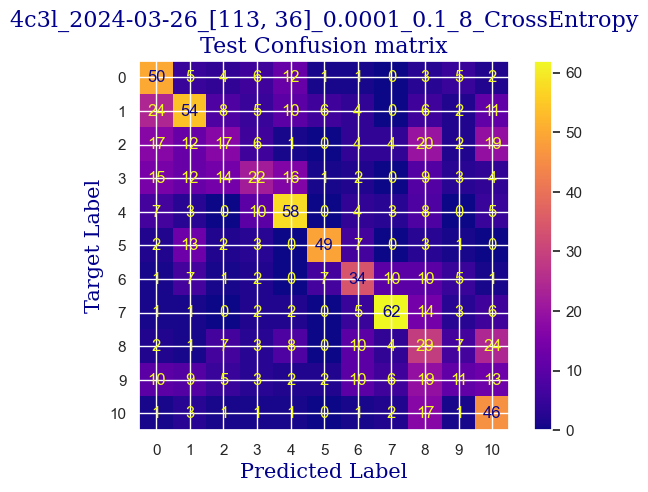

 
 END 4c3l [113, 36] Run Time:  459.472551523
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
1847.722516992
1837.159761906
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.637120761451518
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:16, 22.96s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.06484235574063
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:46, 22.61s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.161213563355146
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:07<06:22, 22.48s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.945865556216537
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:31<06:06, 22.94s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:54<05:43, 22.87s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.886377156454492
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:16<05:17, 22.71s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:38<04:51, 22.45s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.57763236168947
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:02<04:34, 22.84s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.291493158834028
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:25<04:13, 23.00s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.291493158834028
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:47<03:47, 22.78s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.875074360499703
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:10<03:24, 22.74s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.600237953599049
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:33<03:02, 22.77s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.291493158834028
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:56<02:41, 23.04s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  15.70493753718025
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:19<02:17, 22.95s/it]

validation accuracy:  17.337031900138697
Training...
train accuracy:  22.248661511005356
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:42<01:54, 22.80s/it]

validation accuracy:  18.446601941747574
Training...
train accuracy:  25.342058298631763
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:04<01:31, 22.75s/it]

validation accuracy:  23.43966712898752
Training...
train accuracy:  26.948245092207017
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:28<01:09, 23.03s/it]

validation accuracy:  24.549237170596395
Training...
train accuracy:  29.268292682926827
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:50<00:45, 22.88s/it]

validation accuracy:  26.629680998613036
Training...
train accuracy:  30.75550267697799
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:13<00:22, 22.81s/it]

validation accuracy:  27.739251040221912
Training...
train accuracy:  33.25401546698394
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:35<00:00, 22.79s/it]

validation accuracy:  25.381414701803052
Testing...


 
 train acc:  33.25401546698394
 
 val acc:  25.381414701803052
 
 test acc:  27.0873786407767


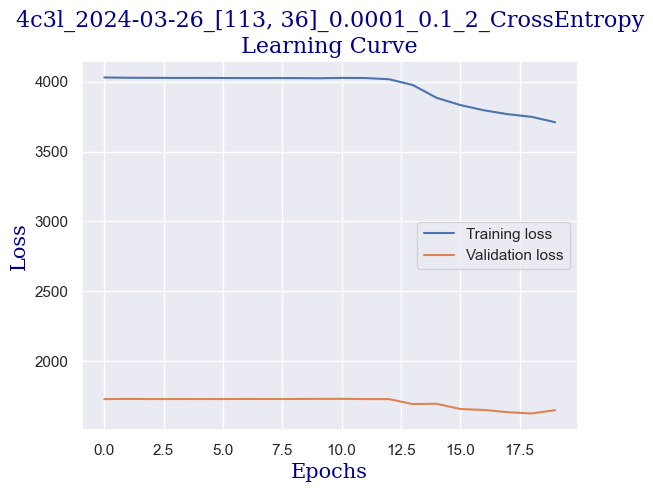

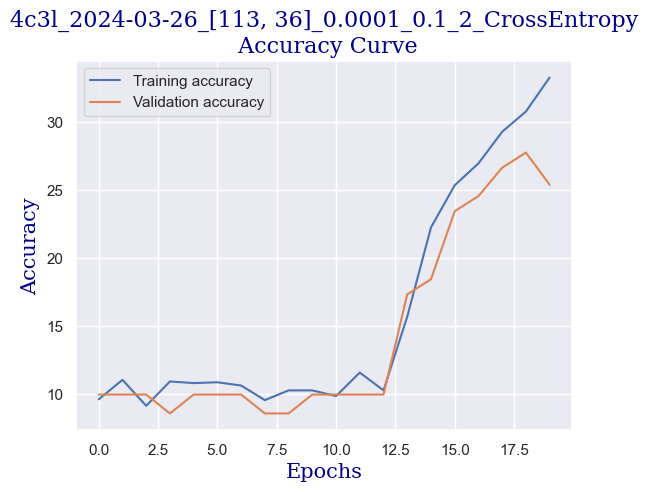

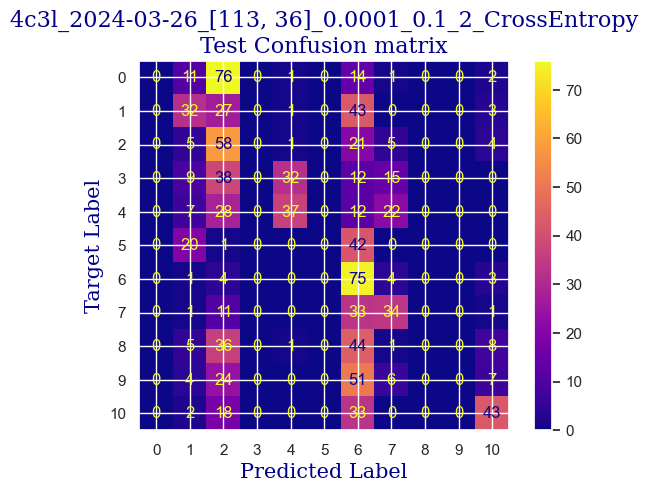

 
 END 4c3l [113, 36] Run Time:  462.6479867370001
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
2310.371558633
2299.808799925
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.886377156454492
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:10, 22.64s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.042236763831053
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:46<06:57, 23.19s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.39916716240333
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:09<06:38, 23.43s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.113027959547887
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:23<05:11, 19.45s/it]

validation accuracy:  7.766990291262135
Training...
train accuracy:  11.481261154074955
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:47<05:15, 21.02s/it]

validation accuracy:  14.979195561719832
Training...
train accuracy:  21.35633551457466
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:09<05:02, 21.60s/it]

validation accuracy:  24.687933425797503
Training...
train accuracy:  28.435455086258184
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:32<04:44, 21.85s/it]

validation accuracy:  27.045769764216367
Training...
train accuracy:  32.59964306960143
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:54<04:25, 22.16s/it]

validation accuracy:  30.513176144244103
Training...
train accuracy:  35.098155859607374
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:18<04:10, 22.73s/it]

validation accuracy:  29.403606102635226
Training...
train accuracy:  37.83462224866151
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:42<03:48, 22.85s/it]

validation accuracy:  29.542302357836338
Training...
train accuracy:  39.38132064247471
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:04<03:25, 22.79s/it]

validation accuracy:  29.680998613037445
Training...
train accuracy:  41.93932183224271
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:27<03:02, 22.83s/it]

validation accuracy:  31.484049930651874
Training...
train accuracy:  42.1772754312909
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:50<02:40, 22.88s/it]

validation accuracy:  32.31622746185853
Training...
train accuracy:  43.60499702558001
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:14<02:19, 23.19s/it]

validation accuracy:  32.593619972260754
Training...
train accuracy:  44.02141582391434
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:37<01:55, 23.14s/it]

validation accuracy:  33.980582524271846
Training...
train accuracy:  43.36704342653183
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:00<01:32, 23.10s/it]

validation accuracy:  33.841886269070734
Training...
train accuracy:  44.6162998215348
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:23<01:08, 22.97s/it]

validation accuracy:  34.674063800277395
Training...
train accuracy:  45.508625817965495
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:46<00:46, 23.14s/it]

validation accuracy:  33.56449375866852
Training...
train accuracy:  46.34146341463415
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:10<00:23, 23.37s/it]

validation accuracy:  35.367545076282944
Training...
train accuracy:  46.162998215348004
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:33<00:00, 22.66s/it]

validation accuracy:  31.622746185852986
Testing...


 
 train acc:  46.162998215348004
 
 val acc:  31.622746185852986
 
 test acc:  36.99029126213592


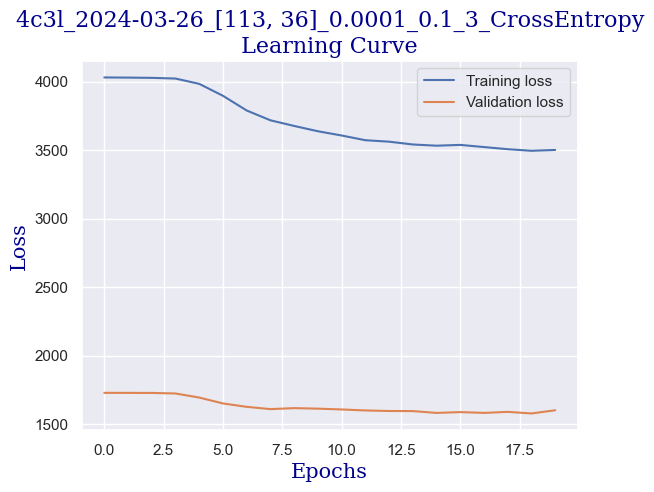

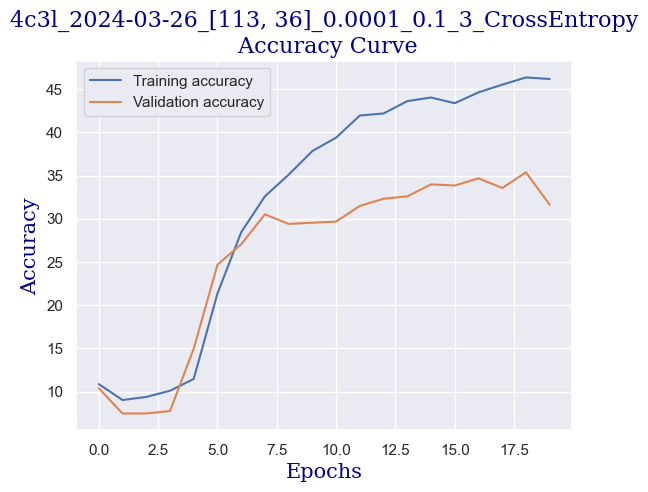

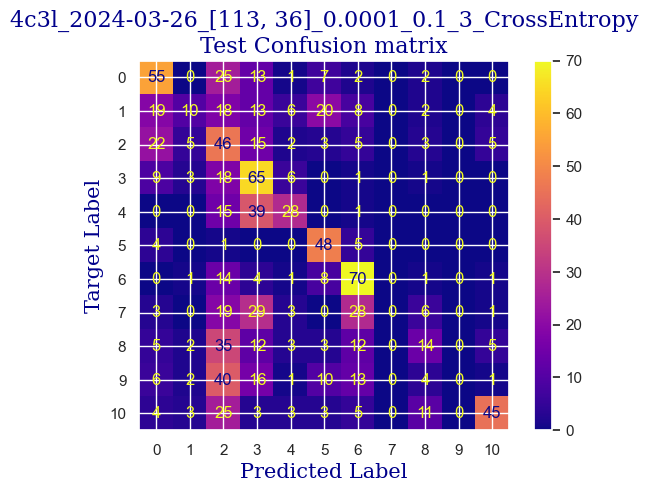

 
 END 4c3l [113, 36] Run Time:  460.20012523900004
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
2770.572699446
2760.009954087
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.804283164782866
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:04, 22.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.39916716240333
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:44<06:38, 22.16s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.447352766210589
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:06<06:17, 22.21s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  14.098750743604995
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:30<06:05, 22.82s/it]

validation accuracy:  24.549237170596395
Training...
train accuracy:  28.078524687685903
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:53<05:41, 22.77s/it]

validation accuracy:  33.00970873786408
Training...
train accuracy:  34.91969066032124
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:15<05:17, 22.71s/it]

validation accuracy:  37.86407766990291
Training...
train accuracy:  37.06127305175491
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:38<04:53, 22.59s/it]

validation accuracy:  39.528432732316226
Training...
train accuracy:  39.202855443188575
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:01<04:35, 22.94s/it]

validation accuracy:  39.66712898751734
Training...
train accuracy:  41.64187983343248
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:25<04:14, 23.12s/it]

validation accuracy:  40.221914008321775
Training...
train accuracy:  41.34443783462225
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:38<03:21, 20.19s/it]

validation accuracy:  41.05409153952843
Training...
train accuracy:  44.79476502082094
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:02<03:10, 21.18s/it]

validation accuracy:  40.49930651872399
Training...
train accuracy:  44.25936942296252
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:25<02:53, 21.68s/it]

validation accuracy:  41.19278779472954
Training...
train accuracy:  45.27067221891731
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:47<02:34, 22.01s/it]

validation accuracy:  42.163661581137305
Training...
train accuracy:  47.41225461035098
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:10<02:13, 22.29s/it]

validation accuracy:  43.41192787794729
Training...
train accuracy:  47.59071980963712
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:34<01:54, 22.81s/it]

validation accuracy:  46.18585298196949
Training...
train accuracy:  48.839976204640095
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:58<01:32, 23.04s/it]

validation accuracy:  44.79889042995839
Training...
train accuracy:  51.516954193932186
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:20<01:08, 22.90s/it]

validation accuracy:  44.521497919556175
Training...
train accuracy:  49.91076740035693
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:43<00:45, 22.87s/it]

validation accuracy:  45.07628294036061
Training...
train accuracy:  51.69541939321832
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:06<00:22, 22.80s/it]

validation accuracy:  44.382801664355064
Training...
train accuracy:  53.42058298631767
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:30<00:00, 22.52s/it]

validation accuracy:  45.76976421636616
Testing...


 
 train acc:  53.42058298631767
 
 val acc:  45.76976421636616
 
 test acc:  43.203883495145625


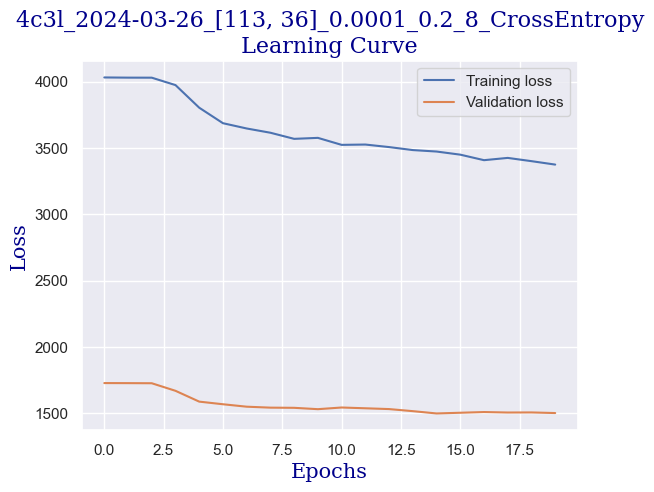

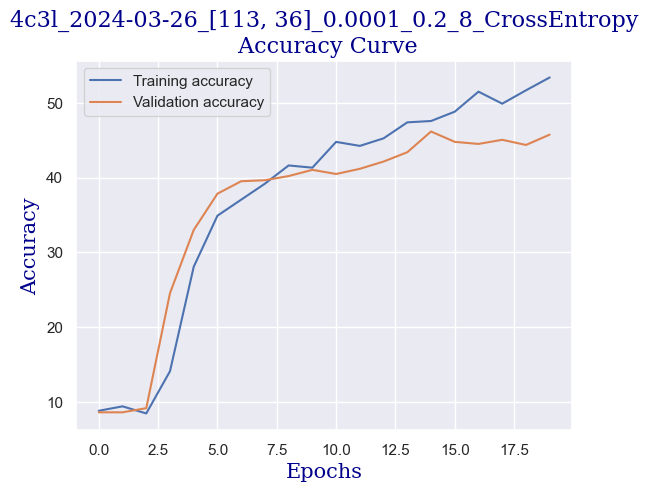

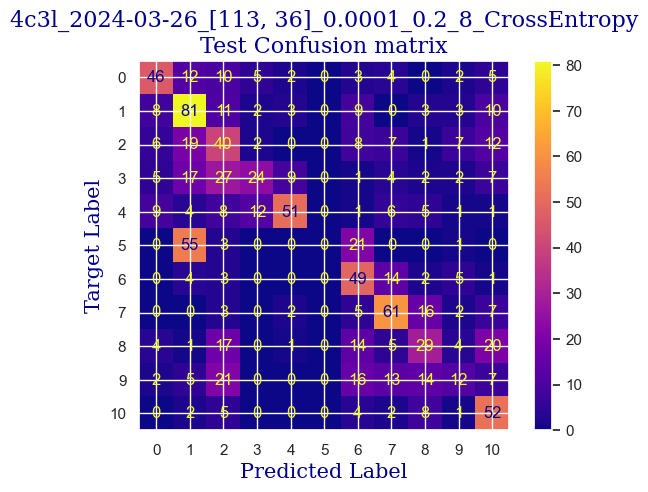

 
 END 4c3l [113, 36] Run Time:  457.4573450170001
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
3228.030890431
3217.468127132
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.637120761451518
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:33, 23.88s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.934562760261748
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:47<07:10, 23.90s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  14.336704342653183
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:10<06:37, 23.39s/it]

validation accuracy:  21.081830790568652
Training...
train accuracy:  23.79535990481856
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:33<06:12, 23.30s/it]

validation accuracy:  24.687933425797503
Training...
train accuracy:  27.959547888161808
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:45, 23.05s/it]

validation accuracy:  25.93619972260749
Training...
train accuracy:  33.31350386674599
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:20<05:27, 23.37s/it]

validation accuracy:  30.651872399445214
Training...
train accuracy:  37.120761451516955
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:44<05:06, 23.57s/it]

validation accuracy:  33.70319001386963
Training...
train accuracy:  40.749553837001784
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:07<04:40, 23.39s/it]

validation accuracy:  34.25797503467407
Training...
train accuracy:  42.89113622843546
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:30<04:15, 23.19s/it]

validation accuracy:  38.55755894590846
Training...
train accuracy:  45.03271861986913
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:52<03:50, 23.08s/it]

validation accuracy:  37.03190013869626
Training...
train accuracy:  46.69839381320642
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:16<03:29, 23.33s/it]

validation accuracy:  35.50624133148405
Training...
train accuracy:  51.21951219512195
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:40<03:07, 23.41s/it]

validation accuracy:  40.77669902912621
Training...
train accuracy:  51.87388459250446
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [05:03<02:42, 23.21s/it]

validation accuracy:  39.1123439667129
Training...
train accuracy:  54.134443783462224
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:25<02:17, 22.99s/it]

validation accuracy:  43.689320388349515
Training...
train accuracy:  55.85960737656157
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:48<01:54, 22.94s/it]

validation accuracy:  43.41192787794729
Training...
train accuracy:  58.77453896490184
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:03<01:21, 20.47s/it]

validation accuracy:  42.71844660194174
Training...
train accuracy:  59.72635336109459
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:25<01:03, 21.11s/it]

validation accuracy:  46.74063800277393
Training...
train accuracy:  60.916121356335516
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:49<00:43, 21.99s/it]

validation accuracy:  45.35367545076283
Training...
train accuracy:  62.522308149910764
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:12<00:22, 22.30s/it]

validation accuracy:  45.214979195561725
Training...
train accuracy:  63.5930993456276
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:35<00:00, 22.78s/it]

validation accuracy:  46.87933425797504
Testing...


 
 train acc:  63.5930993456276
 
 val acc:  46.87933425797504
 
 test acc:  44.1747572815534


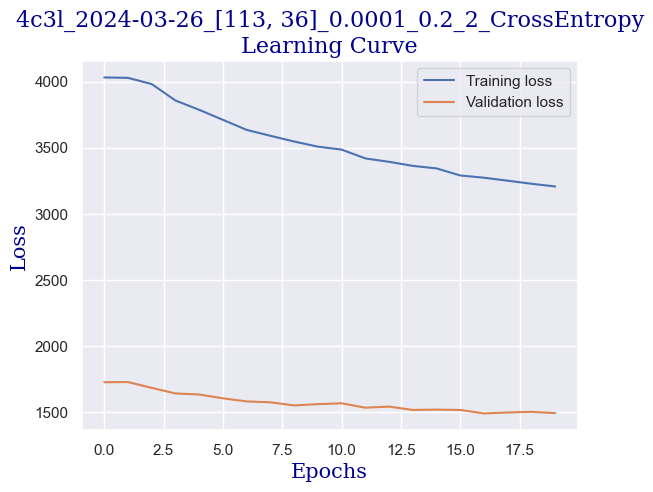

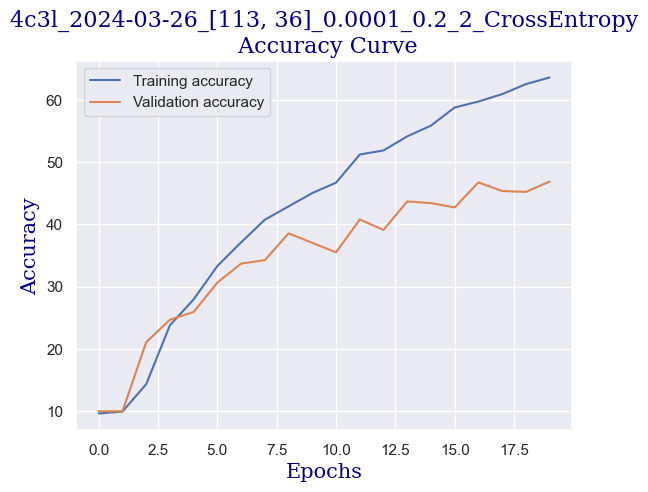

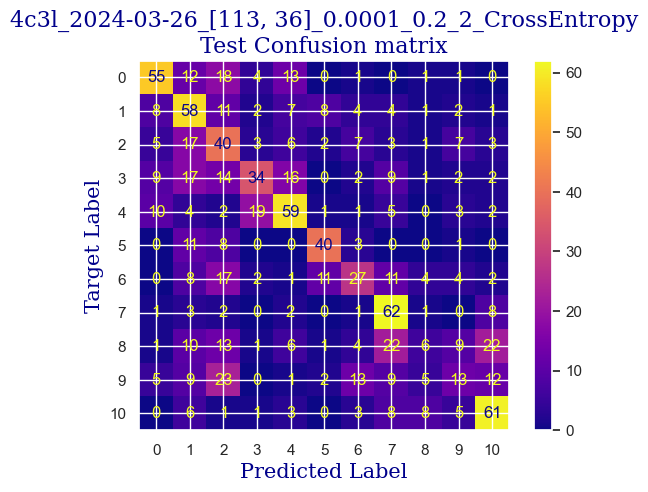

 
 END 4c3l [113, 36] Run Time:  462.28871860300023
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  0.0001   idx: 0 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
3690.320662462
3679.757902139
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.923259964306961
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:13, 22.82s/it]

validation accuracy:  9.57004160887656
Training...
train accuracy:  9.75609756097561
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:49, 22.75s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:28, 22.87s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:32<06:13, 23.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:51, 23.46s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:19<05:27, 23.37s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.707911957168353
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:42<05:02, 23.24s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  13.2064247471743
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:05<04:37, 23.09s/it]

validation accuracy:  17.198335644937586
Training...
train accuracy:  24.15229030339084
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:29<04:18, 23.46s/it]

validation accuracy:  25.52011095700416
Training...
train accuracy:  30.517549077929807
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:52<03:54, 23.47s/it]

validation accuracy:  28.9875173370319
Training...
train accuracy:  34.50327186198691
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:15<03:29, 23.32s/it]

validation accuracy:  30.79056865464632
Training...
train accuracy:  35.574063057703746
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:38<03:05, 23.16s/it]

validation accuracy:  32.87101248266297
Training...
train accuracy:  36.70434265318263
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [05:01<02:41, 23.01s/it]

validation accuracy:  34.11927877947296
Training...
train accuracy:  38.07257584770969
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:25<02:20, 23.37s/it]

validation accuracy:  34.25797503467407
Training...
train accuracy:  40.63057703747769
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:48<01:56, 23.27s/it]

validation accuracy:  34.812760055478506
Training...
train accuracy:  43.12908982748364
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:11<01:32, 23.20s/it]

validation accuracy:  38.00277392510402
Training...
train accuracy:  44.854253420582985
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:34<01:09, 23.18s/it]

validation accuracy:  38.55755894590846
Training...
train accuracy:  45.508625817965495
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:57<00:46, 23.13s/it]

validation accuracy:  40.915395284327325
Training...
train accuracy:  47.41225461035098
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:21<00:23, 23.38s/it]

validation accuracy:  41.60887656033287
Training...
train accuracy:  49.196906603212376
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:44<00:00, 23.24s/it]

validation accuracy:  43.13453536754508
Testing...


 
 train acc:  49.196906603212376
 
 val acc:  43.13453536754508
 
 test acc:  44.1747572815534


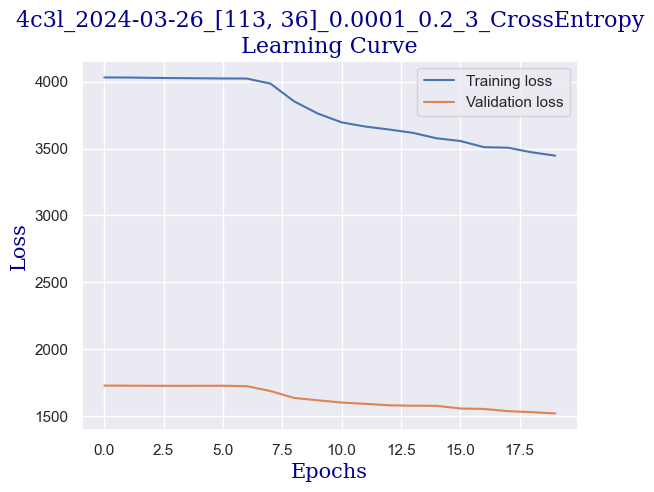

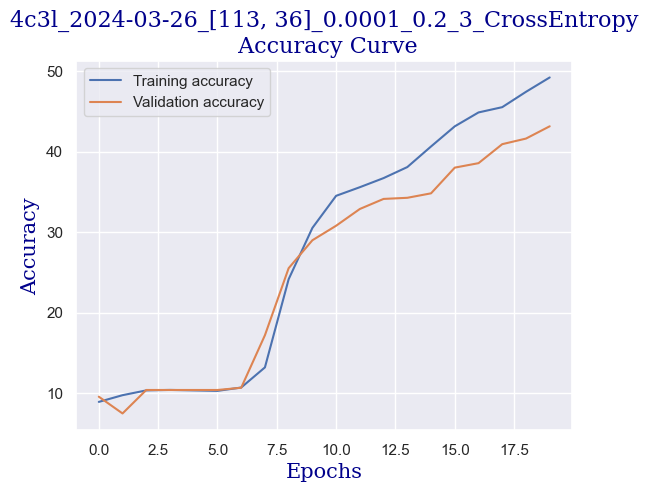

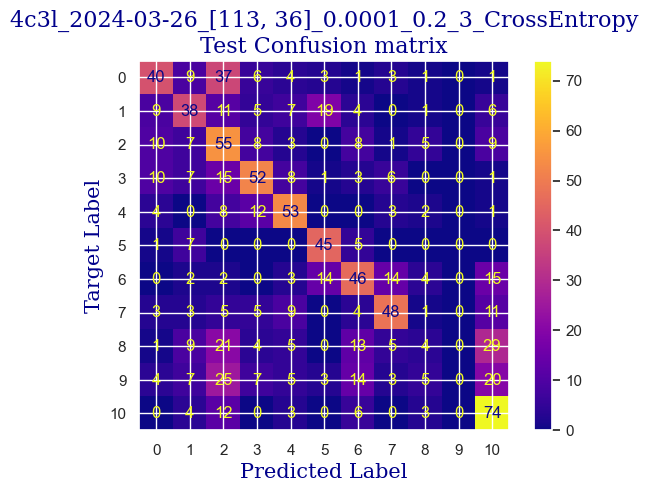

 
 END 4c3l [113, 36] Run Time:  471.5665406659996
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
4161.888525813
4151.325775826
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.875074360499703
validating...


  5%|█████▌                                                                                                          | 1/20 [00:13<04:18, 13.59s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.339678762641284
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:37<05:50, 19.47s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.280190362879239
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:00<05:57, 21.03s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.707911957168353
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:21<05:41, 21.36s/it]

validation accuracy:  15.950069348127602
Training...
train accuracy:  17.311124330755504
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:44<05:25, 21.71s/it]

validation accuracy:  22.46879334257975
Training...
train accuracy:  27.60261748958953
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:07<05:11, 22.28s/it]

validation accuracy:  33.70319001386963
Training...
train accuracy:  30.279595478881618
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:30<04:52, 22.48s/it]

validation accuracy:  36.615811373092924
Training...
train accuracy:  35.693039857227845
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:52<04:27, 22.29s/it]

validation accuracy:  38.00277392510402
Training...
train accuracy:  39.14336704342653
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:14<04:04, 22.19s/it]

validation accuracy:  38.69625520110957
Training...
train accuracy:  40.214158239143366
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:37<03:44, 22.44s/it]

validation accuracy:  41.47018030513176
Training...
train accuracy:  41.46341463414634
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [03:59<03:20, 22.33s/it]

validation accuracy:  39.80582524271845
Training...
train accuracy:  42.35574063057704
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:21<02:57, 22.23s/it]

validation accuracy:  38.97364771151179
Training...
train accuracy:  43.842950624628195
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:43<02:35, 22.16s/it]

validation accuracy:  42.57975034674064
Training...
train accuracy:  43.24806662700773
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:06<02:14, 22.50s/it]

validation accuracy:  41.05409153952843
Training...
train accuracy:  45.27067221891731
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:28<01:51, 22.32s/it]

validation accuracy:  40.915395284327325
Training...
train accuracy:  46.162998215348004
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:50<01:29, 22.32s/it]

validation accuracy:  42.995839112343965
Training...
train accuracy:  48.24509220701963
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:12<01:06, 22.18s/it]

validation accuracy:  43.27323162274618
Training...
train accuracy:  47.293277810826886
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:35<00:44, 22.38s/it]

validation accuracy:  44.382801664355064
Training...
train accuracy:  49.13741820345033
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [06:57<00:22, 22.26s/it]

validation accuracy:  43.828016643550626
Training...
train accuracy:  48.66151100535396
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:19<00:00, 21.99s/it]

validation accuracy:  43.96671289875174
Testing...


 
 train acc:  48.66151100535396
 
 val acc:  43.96671289875174
 
 test acc:  40.19417475728155


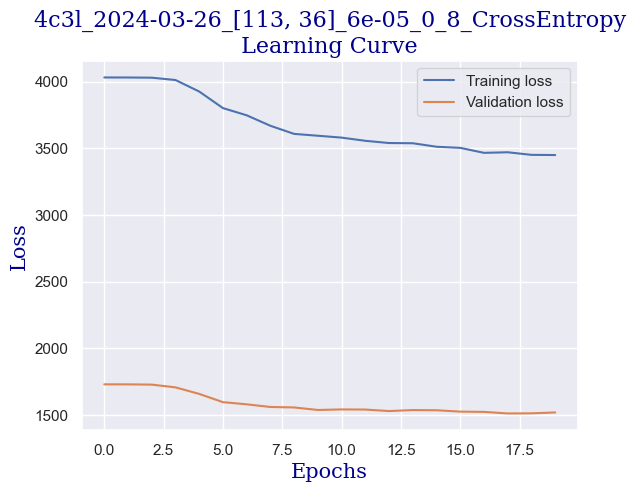

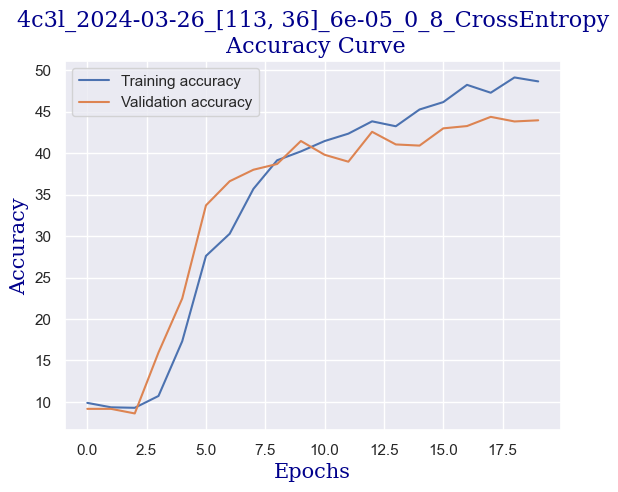

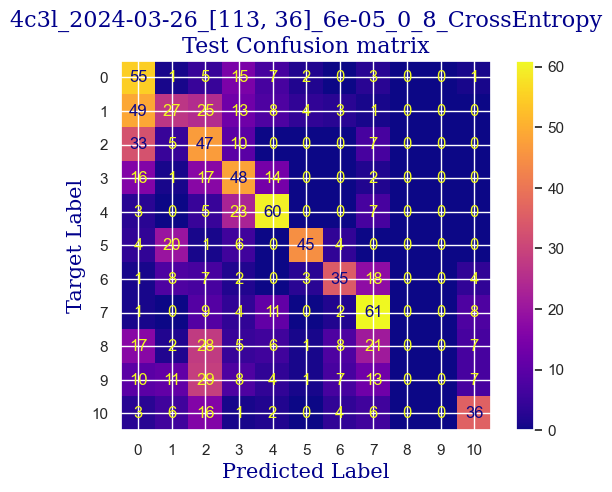

 
 END 4c3l [113, 36] Run Time:  447.1827745949995
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
4609.072225752
4598.5094633
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.220701963117191
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<06:59, 22.05s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.994051160023796
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:44<06:39, 22.21s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.053539559785841
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:07<06:23, 22.57s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.042236763831053
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:29<05:58, 22.39s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.113027959547887
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:51<05:33, 22.25s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.469958358120167
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:14<05:14, 22.45s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.41046995835812
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:37<04:53, 22.60s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.767400356930398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:51<03:57, 19.79s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:14<03:49, 20.84s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.291493158834028
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:36<03:34, 21.43s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.183819155264723
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [03:59<03:17, 21.90s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  12.790005948839978
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:22<02:57, 22.22s/it]

validation accuracy:  12.205270457697642
Training...
train accuracy:  18.500892325996432
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:46<02:38, 22.71s/it]

validation accuracy:  21.7753120665742
Training...
train accuracy:  25.758477096966093
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:09<02:16, 22.68s/it]

validation accuracy:  25.79750346740638
Training...
train accuracy:  16.121356335514577
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:31<01:53, 22.67s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.042236763831053
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:54<01:30, 22.64s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.1017251635931
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:18<01:08, 23.00s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.1017251635931
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:42<00:46, 23.27s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.1017251635931
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:05<00:23, 23.17s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.1017251635931
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:27<00:00, 22.40s/it]

validation accuracy:  10.679611650485436
Testing...


 
 train acc:  9.1017251635931
 
 val acc:  10.679611650485436
 
 test acc:  10.29126213592233


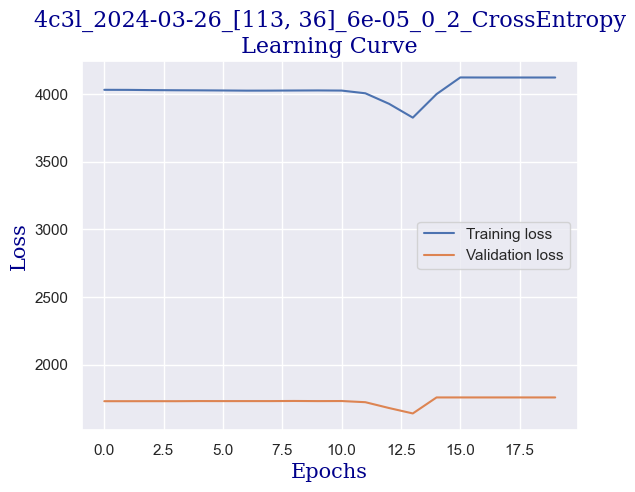

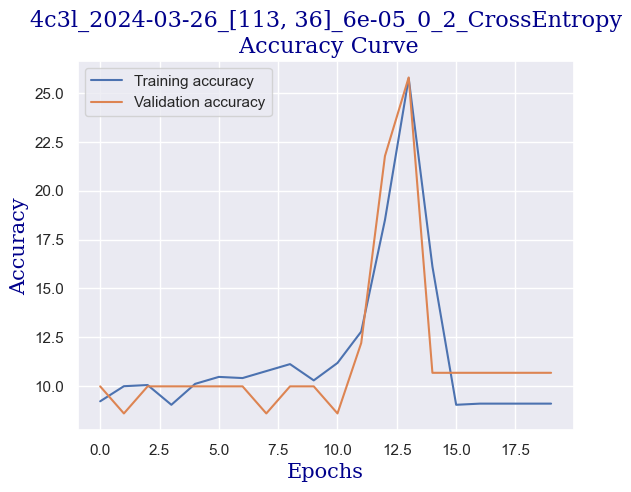

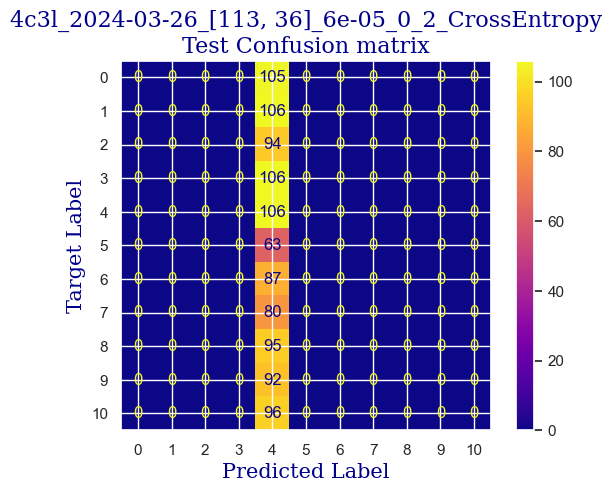

 
 END 4c3l [113, 36] Run Time:  454.98242043499977
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
5064.055522358
5053.492759607
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.875074360499703
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:08, 22.53s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.994051160023796
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:45, 22.51s/it]

validation accuracy:  11.511789181692095
Training...
train accuracy:  9.39916716240333
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:09<06:35, 23.24s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.767400356930398
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:32<06:13, 23.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.458655562165378
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:55<05:46, 23.09s/it]

validation accuracy:  10.957004160887656
Training...
train accuracy:  9.339678762641284
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:17<05:21, 22.94s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  18.79833432480666
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:40<04:56, 22.83s/it]

validation accuracy:  25.104022191400833
Training...
train accuracy:  28.851873884592504
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:04<04:37, 23.09s/it]

validation accuracy:  29.126213592233007
Training...
train accuracy:  31.528851873884594
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:26<04:11, 22.91s/it]

validation accuracy:  29.126213592233007
Training...
train accuracy:  35.098155859607374
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:49<03:47, 22.78s/it]

validation accuracy:  35.92233009708738
Training...
train accuracy:  39.67876264128495
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:11<03:25, 22.78s/it]

validation accuracy:  38.69625520110957
Training...
train accuracy:  43.66448542534206
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:35<03:04, 23.00s/it]

validation accuracy:  43.41192787794729
Training...
train accuracy:  45.44913741820345
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:57<02:39, 22.85s/it]

validation accuracy:  42.163661581137305
Training...
train accuracy:  46.936347412254605
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:14<02:05, 20.89s/it]

validation accuracy:  45.90846047156727
Training...
train accuracy:  50.386674598453304
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:34<01:44, 20.81s/it]

validation accuracy:  42.857142857142854
Training...
train accuracy:  51.39797739440809
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:57<01:25, 21.43s/it]

validation accuracy:  48.40499306518724
Training...
train accuracy:  54.43188578227246
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:20<01:05, 21.90s/it]

validation accuracy:  46.601941747572816
Training...
train accuracy:  54.37239738251041
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:44<00:44, 22.47s/it]

validation accuracy:  46.74063800277393
Training...
train accuracy:  56.33551457465794
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:08<00:22, 22.91s/it]

validation accuracy:  47.57281553398058
Training...
train accuracy:  57.049375371802505
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:31<00:00, 22.56s/it]

validation accuracy:  45.214979195561725
Testing...


 
 train acc:  57.049375371802505
 
 val acc:  45.214979195561725
 
 test acc:  44.95145631067961


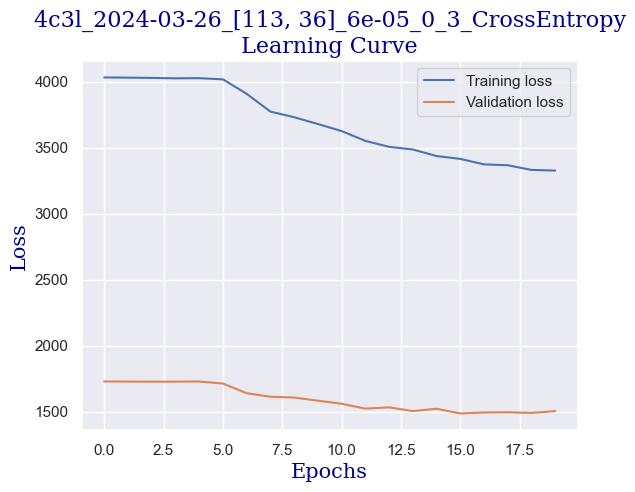

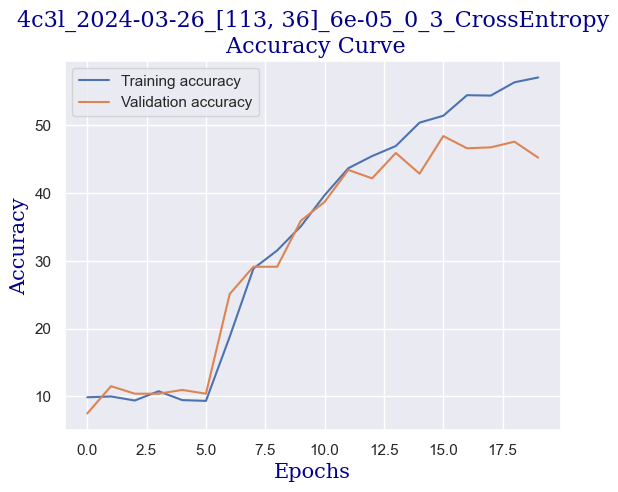

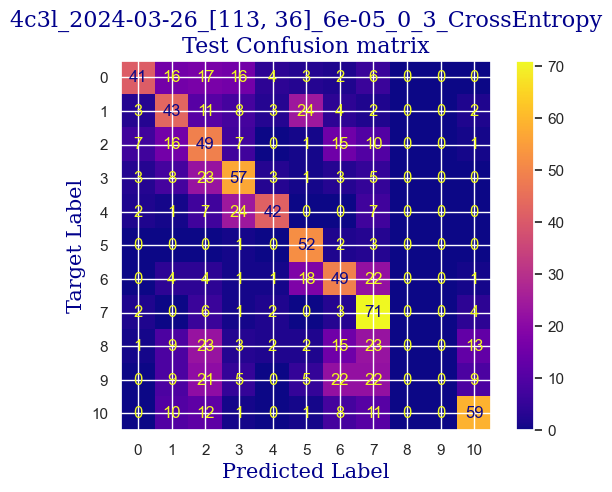

 
 END 4c3l [113, 36] Run Time:  458.1712228769993
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
5522.227740736
5511.664979734
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.875074360499703
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:12, 22.77s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.113027959547887
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:50, 22.81s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:27, 22.77s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.696609161213564
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:31<06:05, 22.85s/it]

validation accuracy:  9.847434119278779
Training...
train accuracy:  15.407495538370016
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:55<05:47, 23.17s/it]

validation accuracy:  20.943134535367545
Training...
train accuracy:  25.580011897679956
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:17<05:20, 22.91s/it]

validation accuracy:  28.29403606102635
Training...
train accuracy:  30.93396787626413
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:39<04:55, 22.74s/it]

validation accuracy:  32.038834951456316
Training...
train accuracy:  35.87150505651398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:02<04:31, 22.64s/it]

validation accuracy:  37.86407766990291
Training...
train accuracy:  40.095181439619274
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:25<04:12, 22.97s/it]

validation accuracy:  36.615811373092924
Training...
train accuracy:  41.522903033908385
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:48<03:49, 22.91s/it]

validation accuracy:  38.83495145631068
Training...
train accuracy:  41.879833432480666
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:11<03:25, 22.83s/it]

validation accuracy:  38.55755894590846
Training...
train accuracy:  45.746579417013685
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:34<03:02, 22.84s/it]

validation accuracy:  40.36061026352289
Training...
train accuracy:  45.627602617489586
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:57<02:41, 23.08s/it]

validation accuracy:  37.586685159500696
Training...
train accuracy:  46.103509815585966
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:21<02:19, 23.18s/it]

validation accuracy:  40.49930651872399
Training...
train accuracy:  46.81737061273052
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:43<01:55, 23.03s/it]

validation accuracy:  35.50624133148405
Training...
train accuracy:  48.958953004164194
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:06<01:31, 22.90s/it]

validation accuracy:  39.80582524271845
Training...
train accuracy:  51.04104699583581
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:29<01:08, 22.87s/it]

validation accuracy:  41.19278779472954
Training...
train accuracy:  51.63593099345628
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:53<00:46, 23.12s/it]

validation accuracy:  42.163661581137305
Training...
train accuracy:  52.0523497917906
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:15<00:22, 22.93s/it]

validation accuracy:  44.66019417475729
Training...
train accuracy:  53.24211778703153
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:33<00:00, 22.66s/it]

validation accuracy:  48.68238557558946
Testing...


 
 train acc:  53.24211778703153
 
 val acc:  48.68238557558946
 
 test acc:  45.728155339805824


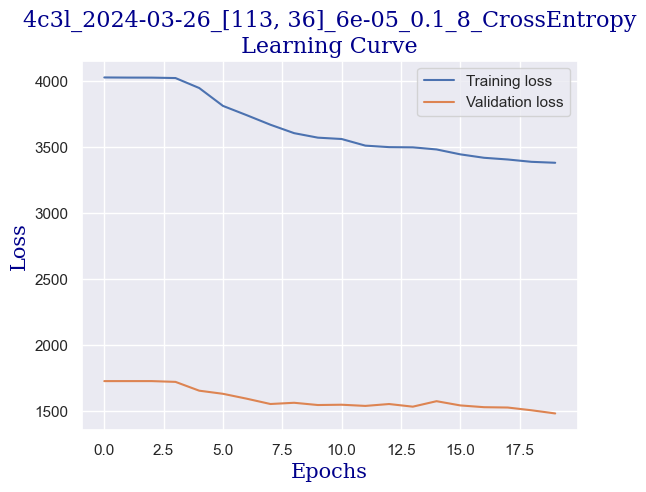

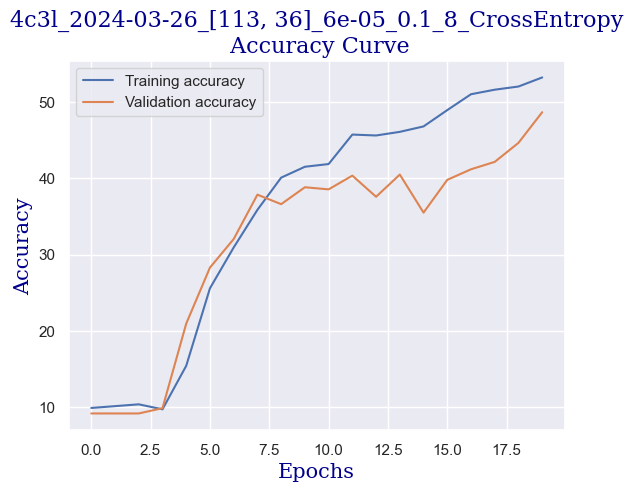

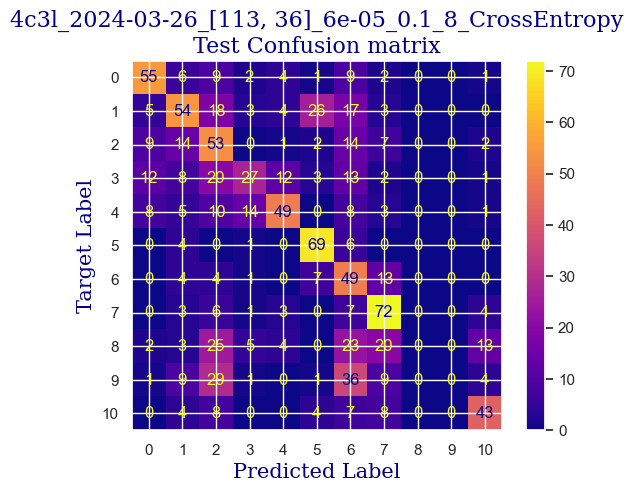

 
 END 4c3l [113, 36] Run Time:  458.8369587570005
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
5981.065603697
5970.502838984
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.1017251635931
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:31, 23.78s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.362284354550862
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:47<07:11, 23.95s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.469958358120167
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:10<06:37, 23.41s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.350981558596075
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:33<06:11, 23.23s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:46, 23.08s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.350981558596075
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:20<05:27, 23.39s/it]

validation accuracy:  9.43134535367545
Training...
train accuracy:  12.671029149315881
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:43<05:02, 23.31s/it]

validation accuracy:  14.285714285714285
Training...
train accuracy:  18.02498512790006
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:05<04:36, 23.04s/it]

validation accuracy:  23.300970873786408
Training...
train accuracy:  26.531826293872697
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:28<04:12, 22.91s/it]

validation accuracy:  28.9875173370319
Training...
train accuracy:  30.04164187983343
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:51<03:49, 22.96s/it]

validation accuracy:  28.01664355062413
Training...
train accuracy:  34.62224866151101
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:15<03:29, 23.28s/it]

validation accuracy:  33.14840499306519
Training...
train accuracy:  37.180249851279
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:38<03:04, 23.08s/it]

validation accuracy:  33.14840499306519
Training...
train accuracy:  39.797739440809046
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [05:00<02:39, 22.83s/it]

validation accuracy:  29.403606102635226
Training...
train accuracy:  41.2849494348602
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:23<02:16, 22.78s/it]

validation accuracy:  37.03190013869626
Training...
train accuracy:  42.59369422962522
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:47<01:55, 23.10s/it]

validation accuracy:  36.47711511789182
Training...
train accuracy:  46.936347412254605
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:10<01:32, 23.19s/it]

validation accuracy:  39.66712898751734
Training...
train accuracy:  49.67281380130875
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:33<01:09, 23.03s/it]

validation accuracy:  43.689320388349515
Training...
train accuracy:  51.04104699583581
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:55<00:45, 22.99s/it]

validation accuracy:  42.302357836338416
Training...
train accuracy:  51.87388459250446
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:18<00:22, 22.93s/it]

validation accuracy:  45.63106796116505
Training...
train accuracy:  51.45746579417013
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:42<00:00, 23.12s/it]

validation accuracy:  41.05409153952843
Testing...


 
 train acc:  51.45746579417013
 
 val acc:  41.05409153952843
 
 test acc:  41.55339805825243


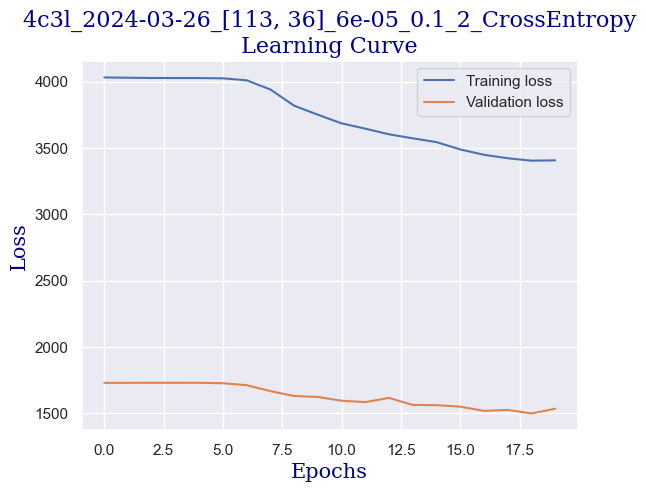

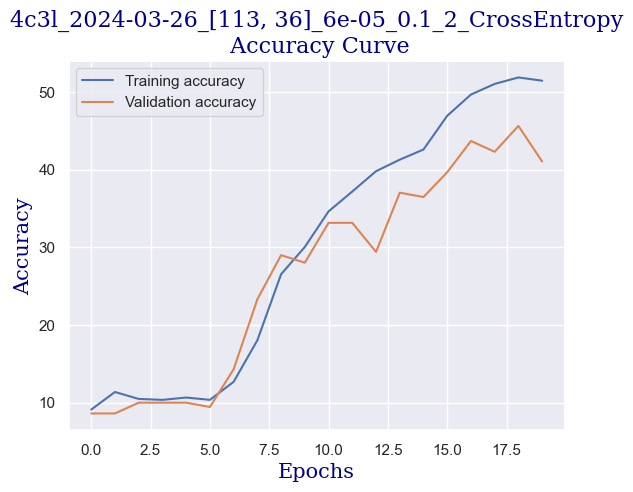

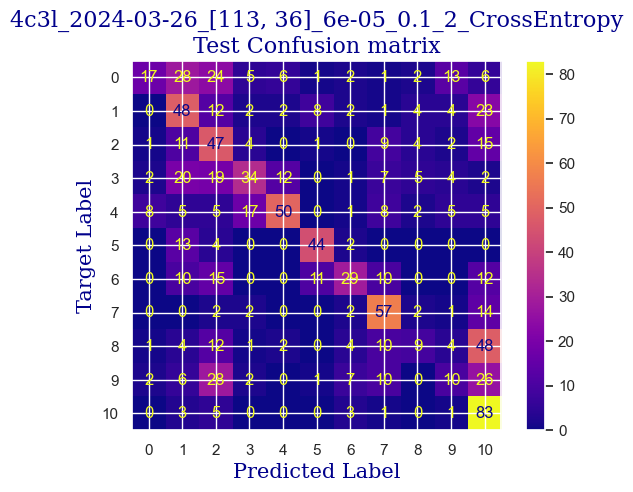

 
 END 4c3l [113, 36] Run Time:  469.46608931099945
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
6450.532891338
6439.970126516
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.113027959547887
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:25, 23.43s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:47<07:07, 23.76s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.113027959547887
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:10<06:36, 23.31s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  13.682331945270674
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:33<06:09, 23.12s/it]

validation accuracy:  18.307905686546462
Training...
train accuracy:  22.48661511005354
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:53<05:33, 22.25s/it]

validation accuracy:  23.300970873786408
Training...
train accuracy:  27.959547888161808
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:10<04:43, 20.22s/it]

validation accuracy:  28.155339805825243
Training...
train accuracy:  33.789411064842355
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:32<04:34, 21.10s/it]

validation accuracy:  31.06796116504854
Training...
train accuracy:  33.55145746579417
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:57<04:24, 22.05s/it]

validation accuracy:  31.900138696255205
Training...
train accuracy:  35.27662105889352
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:20<04:08, 22.60s/it]

validation accuracy:  33.42579750346741
Training...
train accuracy:  36.64485425342058
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:43<03:46, 22.66s/it]

validation accuracy:  34.95145631067961
Training...
train accuracy:  38.07257584770969
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:06<03:24, 22.77s/it]

validation accuracy:  35.64493758668516
Training...
train accuracy:  39.26234384295063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:29<03:01, 22.71s/it]

validation accuracy:  35.64493758668516
Training...
train accuracy:  40.03569303985723
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:53<02:41, 23.07s/it]

validation accuracy:  38.00277392510402
Training...
train accuracy:  41.4039262343843
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:15<02:18, 23.02s/it]

validation accuracy:  38.83495145631068
Training...
train accuracy:  42.653182629387274
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:38<01:54, 22.96s/it]

validation accuracy:  38.55755894590846
Training...
train accuracy:  43.069601427721594
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:01<01:31, 22.88s/it]

validation accuracy:  37.586685159500696
Training...
train accuracy:  42.71267102914932
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:25<01:09, 23.09s/it]

validation accuracy:  38.41886269070735
Training...
train accuracy:  43.426531826293875
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:48<00:46, 23.29s/it]

validation accuracy:  40.36061026352289
Training...
train accuracy:  45.80606781677573
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:11<00:22, 22.99s/it]

validation accuracy:  42.163661581137305
Training...
train accuracy:  48.483045806067814
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:33<00:00, 22.69s/it]

validation accuracy:  39.80582524271845
Testing...


 
 train acc:  48.483045806067814
 
 val acc:  39.80582524271845
 
 test acc:  43.883495145631066


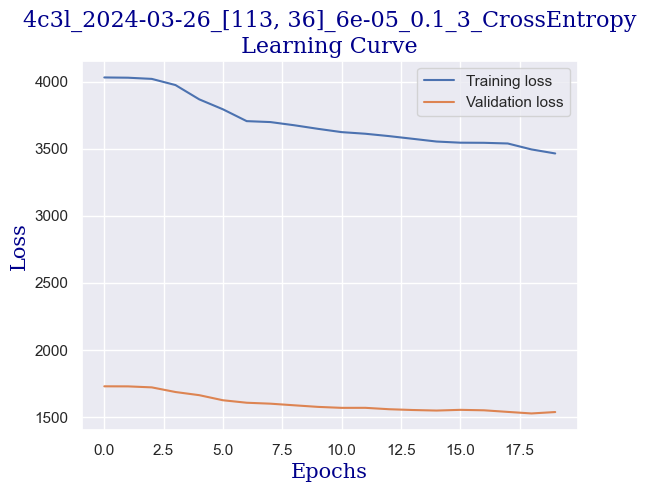

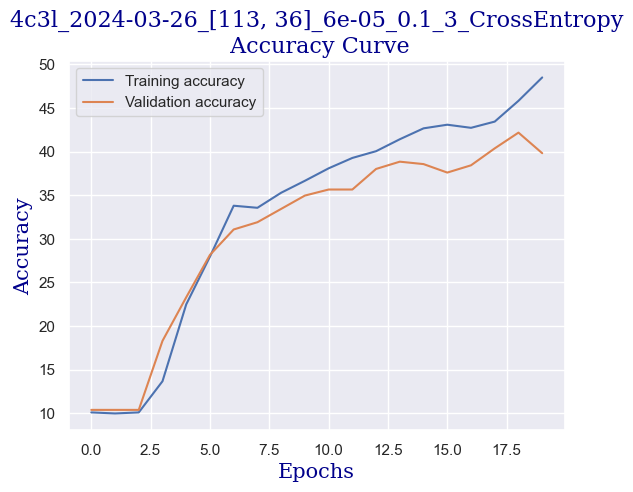

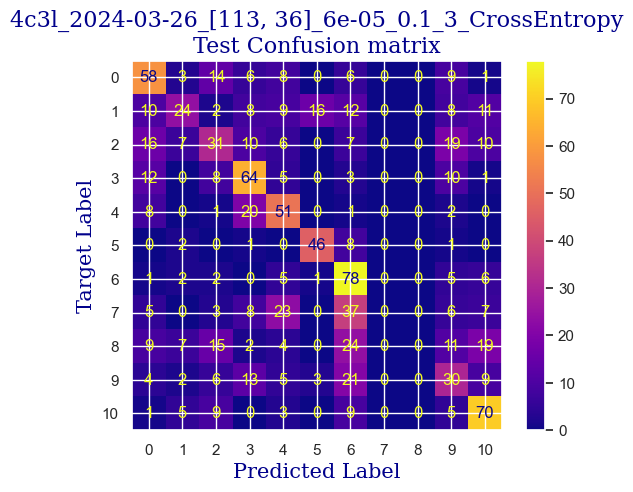

 
 END 4c3l [113, 36] Run Time:  460.9249874540001
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
6911.458723795
6900.895959612
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.685306365258775
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:08, 22.57s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.220701963117191
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:50, 22.78s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  8.923259964306961
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:09<06:34, 23.23s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.41046995835812
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:32<06:11, 23.25s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.291493158834028
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:55<05:47, 23.14s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.529446757882214
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:18<05:21, 22.98s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.58893515764426
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:41<04:59, 23.00s/it]

validation accuracy:  14.424410540915394
Training...
train accuracy:  22.248661511005356
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:05<04:39, 23.30s/it]

validation accuracy:  29.819694868238557
Training...
train accuracy:  30.220107079119572
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:27<04:13, 23.00s/it]

validation accuracy:  32.87101248266297
Training...
train accuracy:  33.908387864366446
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:50<03:49, 22.91s/it]

validation accuracy:  34.25797503467407
Training...
train accuracy:  35.336109458655564
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:12<03:25, 22.79s/it]

validation accuracy:  36.47711511789182
Training...
train accuracy:  37.83462224866151
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:27<02:42, 20.32s/it]

validation accuracy:  36.754507628294036
Training...
train accuracy:  40.214158239143366
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:50<02:27, 21.02s/it]

validation accuracy:  32.87101248266297
Training...
train accuracy:  41.16597263533611
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:14<02:11, 21.99s/it]

validation accuracy:  34.95145631067961
Training...
train accuracy:  43.307555026769776
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:37<01:51, 22.26s/it]

validation accuracy:  40.77669902912621
Training...
train accuracy:  43.90243902439025
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:59<01:29, 22.36s/it]

validation accuracy:  38.83495145631068
Training...
train accuracy:  46.57941701368233
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:22<01:07, 22.48s/it]

validation accuracy:  42.57975034674064
Training...
train accuracy:  48.89946460440214
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:45<00:45, 22.70s/it]

validation accuracy:  43.5506241331484
Training...
train accuracy:  50.148720999405114
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:09<00:23, 23.07s/it]

validation accuracy:  44.79889042995839
Training...
train accuracy:  51.87388459250446
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:32<00:00, 22.63s/it]

validation accuracy:  46.87933425797504
Testing...


 
 train acc:  51.87388459250446
 
 val acc:  46.87933425797504
 
 test acc:  43.203883495145625


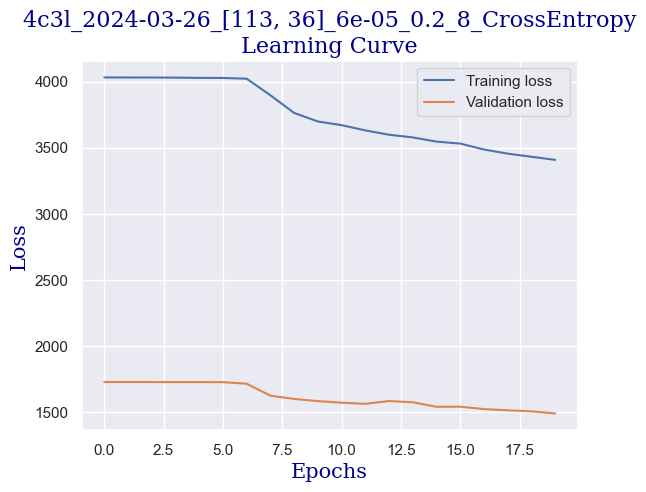

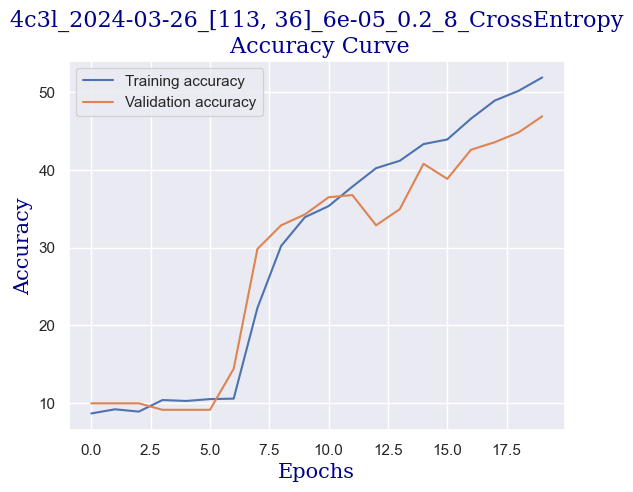

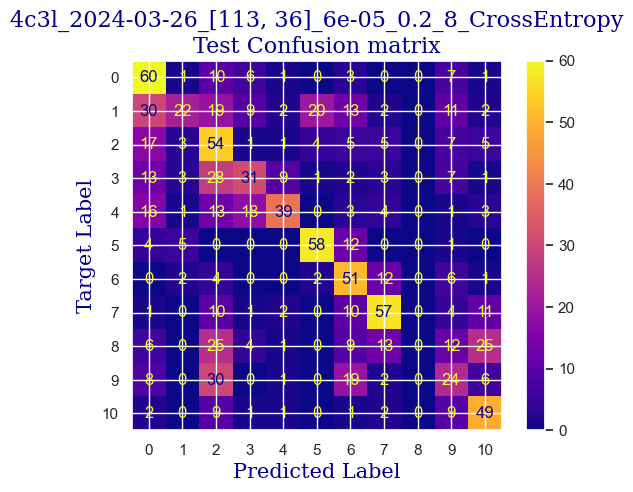

 
 END 4c3l [113, 36] Run Time:  459.5369799359996
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
7370.996836173
7360.434080755
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.767400356930398
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:24, 23.41s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:46<06:54, 23.01s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.659726353361094
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:28, 22.83s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.529446757882214
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:31<06:06, 22.91s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:55<05:49, 23.29s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:18<05:24, 23.16s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:41<04:58, 22.98s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.529446757882214
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:04<04:35, 22.97s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.469958358120167
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:27<04:13, 23.00s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  12.195121951219512
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:51<03:54, 23.40s/it]

validation accuracy:  11.511789181692095
Training...
train accuracy:  17.668054729327782
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:14<03:28, 23.17s/it]

validation accuracy:  15.117891816920942
Training...
train accuracy:  20.582986317668055
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:37<03:04, 23.09s/it]

validation accuracy:  19.41747572815534
Training...
train accuracy:  24.033313503866747
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:59<02:41, 23.00s/it]

validation accuracy:  23.994452149791957
Training...
train accuracy:  26.4128494943486
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:23<02:19, 23.25s/it]

validation accuracy:  23.300970873786408
Training...
train accuracy:  28.673408685306367
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:47<01:57, 23.42s/it]

validation accuracy:  30.929264909847433
Training...
train accuracy:  31.231409875074363
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:10<01:32, 23.16s/it]

validation accuracy:  29.403606102635226
Training...
train accuracy:  33.31350386674599
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:27<01:04, 21.51s/it]

validation accuracy:  31.484049930651874
Training...
train accuracy:  33.8488994646044
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:47<00:42, 21.00s/it]

validation accuracy:  30.513176144244103
Training...
train accuracy:  34.97917906008328
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:09<00:21, 21.27s/it]

validation accuracy:  29.26490984743412
Training...
train accuracy:  37.23973825104105
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:31<00:00, 22.59s/it]

validation accuracy:  32.593619972260754
Testing...


 
 train acc:  37.23973825104105
 
 val acc:  32.593619972260754
 
 test acc:  34.75728155339806


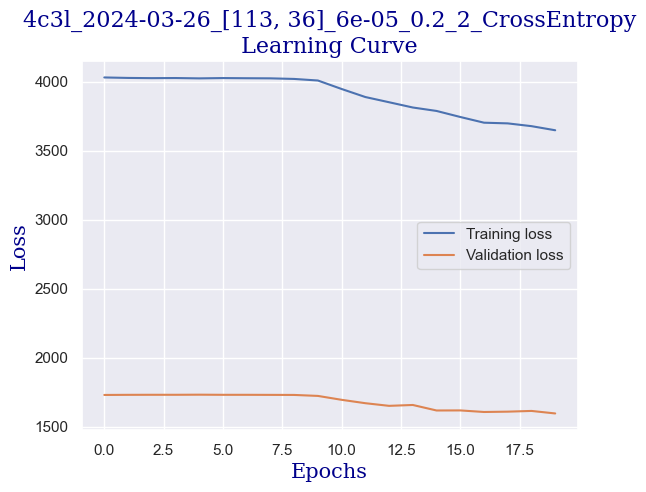

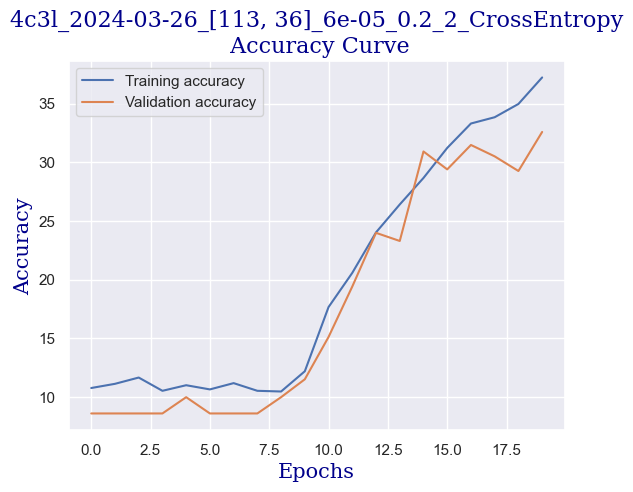

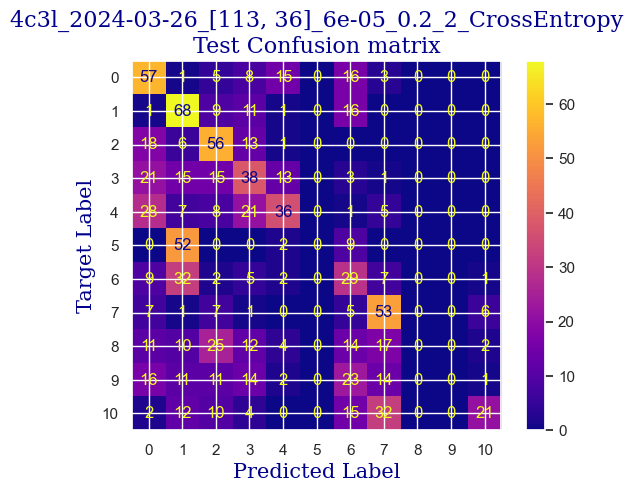

 
 END 4c3l [113, 36] Run Time:  458.9277037520005
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  6e-05   idx: 1 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
7829.925451248
7819.362684844
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.280190362879239
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:02, 22.22s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.529446757882214
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:49, 22.73s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.57763236168947
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:07<06:20, 22.40s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.815585960737657
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:29<05:56, 22.26s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:51<05:31, 22.12s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  12.135633551457465
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:14<05:14, 22.49s/it]

validation accuracy:  17.614424410540916
Training...
train accuracy:  23.67638310529447
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:36<04:51, 22.41s/it]

validation accuracy:  28.43273231622746
Training...
train accuracy:  29.38726948245092
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:58<04:28, 22.35s/it]

validation accuracy:  30.651872399445214
Training...
train accuracy:  32.59964306960143
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:21<04:07, 22.47s/it]

validation accuracy:  31.06796116504854
Training...
train accuracy:  35.63355145746579
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:44<03:47, 22.71s/it]

validation accuracy:  34.39667128987517
Training...
train accuracy:  37.29922665080309
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:06<03:22, 22.46s/it]

validation accuracy:  33.14840499306519
Training...
train accuracy:  37.71564544913742
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:28<02:58, 22.34s/it]

validation accuracy:  36.615811373092924
Training...
train accuracy:  40.63057703747769
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:51<02:37, 22.56s/it]

validation accuracy:  34.95145631067961
Training...
train accuracy:  39.38132064247471
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:14<02:15, 22.62s/it]

validation accuracy:  36.754507628294036
Training...
train accuracy:  41.106484235574065
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:36<01:52, 22.48s/it]

validation accuracy:  35.22884882108183
Training...
train accuracy:  43.188578227245685
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:58<01:29, 22.35s/it]

validation accuracy:  38.83495145631068
Training...
train accuracy:  43.069601427721594
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:22<01:07, 22.60s/it]

validation accuracy:  30.929264909847433
Training...
train accuracy:  45.03271861986913
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:44<00:45, 22.60s/it]

validation accuracy:  42.44105409153953
Training...
train accuracy:  45.746579417013685
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:06<00:22, 22.43s/it]

validation accuracy:  43.828016643550626
Training...
train accuracy:  47.055324211778704
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:28<00:00, 22.44s/it]

validation accuracy:  46.04715672676838
Testing...


 
 train acc:  47.055324211778704
 
 val acc:  46.04715672676838
 
 test acc:  44.1747572815534


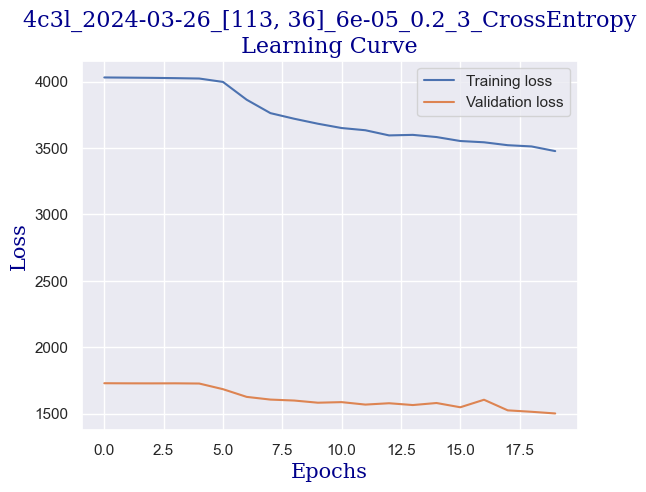

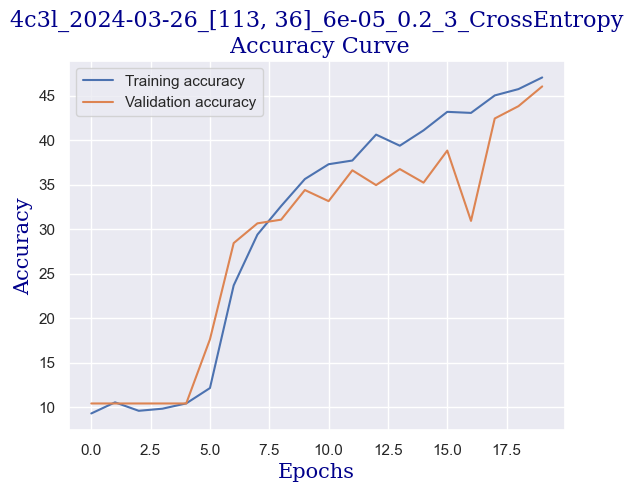

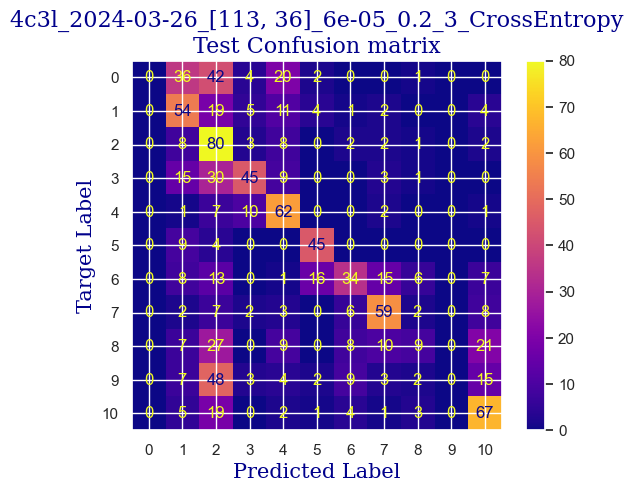

 
 END 4c3l [113, 36] Run Time:  455.86430582399953
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  7e-05   idx: 2 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
8285.790955816
8275.22819333
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.875074360499703
validating...


  5%|█████▌                                                                                                          | 1/20 [00:22<07:03, 22.30s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.518143961927423
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:45<06:54, 23.04s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  11.89767995240928
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:32, 23.08s/it]

validation accuracy:  19.41747572815534
Training...
train accuracy:  19.631171921475314
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:22<05:11, 19.49s/it]

validation accuracy:  23.855755894590846
Training...
train accuracy:  25.698988697204044
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:45<05:09, 20.64s/it]

validation accuracy:  30.79056865464632
Training...
train accuracy:  32.480666270077336
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:08<04:59, 21.36s/it]

validation accuracy:  30.651872399445214
Training...
train accuracy:  35.87150505651398
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:31<04:44, 21.90s/it]

validation accuracy:  31.622746185852986
Training...
train accuracy:  37.71564544913742
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [02:54<04:26, 22.18s/it]

validation accuracy:  35.367545076282944
Training...
train accuracy:  39.202855443188575
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:18<04:10, 22.76s/it]

validation accuracy:  35.64493758668516
Training...
train accuracy:  42.0582986317668
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:41<03:48, 22.82s/it]

validation accuracy:  37.586685159500696
Training...
train accuracy:  44.02141582391434
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:03<03:25, 22.81s/it]

validation accuracy:  37.17059639389736
Training...
train accuracy:  46.46044021415824
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:26<03:02, 22.80s/it]

validation accuracy:  41.74757281553398
Training...
train accuracy:  47.65020820939917
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:49<02:40, 22.88s/it]

validation accuracy:  42.44105409153953
Training...
train accuracy:  49.732302201070794
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:14<02:19, 23.29s/it]

validation accuracy:  42.857142857142854
Training...
train accuracy:  50.86258179654968
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:37<01:55, 23.19s/it]

validation accuracy:  38.41886269070735
Training...
train accuracy:  53.004164187983335
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [05:59<01:32, 23.09s/it]

validation accuracy:  42.995839112343965
Training...
train accuracy:  53.7180249851279
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [06:22<01:08, 22.90s/it]

validation accuracy:  42.857142857142854
Training...
train accuracy:  55.502676977989296
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [06:46<00:46, 23.21s/it]

validation accuracy:  44.24410540915395
Training...
train accuracy:  55.85960737656157
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [07:10<00:23, 23.43s/it]

validation accuracy:  41.60887656033287
Training...
train accuracy:  57.28732897085068
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:32<00:00, 22.64s/it]

validation accuracy:  41.05409153952843
Testing...


 
 train acc:  57.28732897085068
 
 val acc:  41.05409153952843
 
 test acc:  39.22330097087379


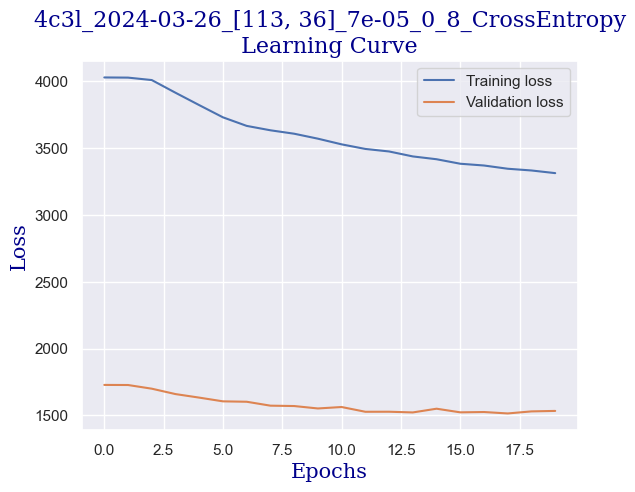

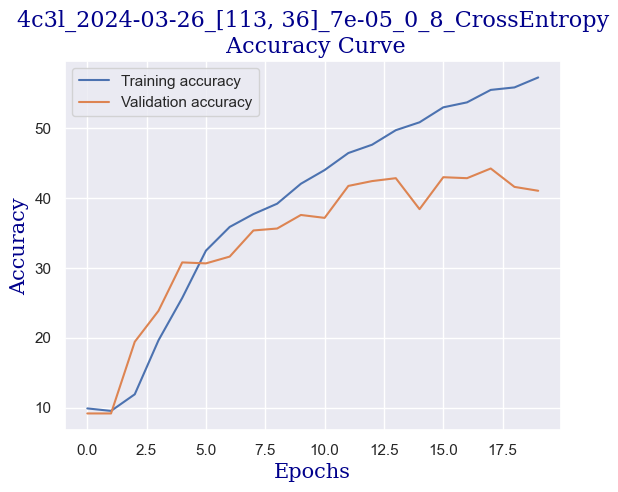

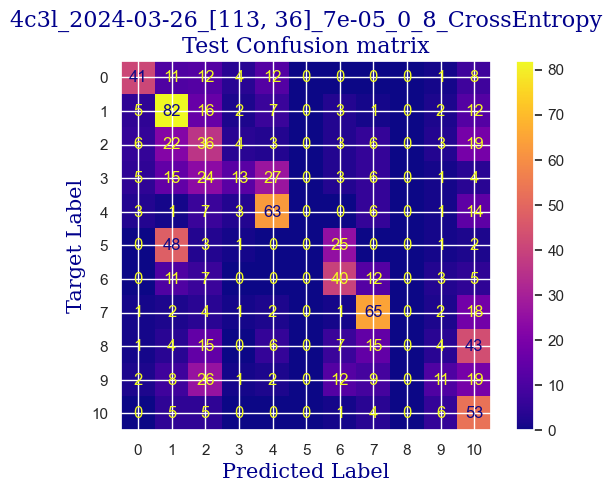

 
 END 4c3l [113, 36] Run Time:  459.72668608299864
Model:  4c3l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 5
learning rate:  7e-05   idx: 2 / 4
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
8745.518550957
8734.955788466
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.566329565734682
validating...


  5%|█████▌                                                                                                          | 1/20 [00:23<07:20, 23.19s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.57763236168947
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:46<06:53, 22.98s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.696609161213564
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:08<06:30, 22.96s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.362284354550862
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:31<06:06, 22.93s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.41046995835812
validating...


 25%|████████████████████████████                                                                                    | 5/20 [01:56<05:51, 23.40s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.06484235574063
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:18<05:24, 23.16s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.469958358120167
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [02:41<04:59, 23.06s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:04<04:36, 23.04s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [03:28<04:16, 23.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.053539559785841
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [03:42<03:23, 20.39s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [04:05<03:11, 21.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.659726353361094
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [04:29<02:56, 22.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.886377156454492
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [04:52<02:36, 22.31s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.529446757882214
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [05:15<02:14, 22.43s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [05:38<01:52, 22.58s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [06:02<01:32, 23.01s/it]

validation accuracy:  9.986130374479888
Training...


In [ ]:
_go(config)